In [1]:
from collections import defaultdict
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../../../visualizations/')
from venn_diagram import venn3_diagram

In [2]:
COLOR1 = "#FF0420"
COLOR2 = "#FF6969"
COLOR3 = "#FFCCDD"

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.family'] = 'Arial'

In [3]:
def load_csv(csv):
    pg_id = 'UNKoHLpnT_OziRiPCuX21uhgLNIJygsxuZz3A0TL-cg='
    pg_slug = 'protocol-guild'
    data = pd.read_csv(csv)
    if 'project_id' in data.columns:
        return data[data['project_id'] != pg_id]
    for col in data.columns:
        if pg_slug in data[col]:
            return data[data[col] != pg_slug]
    return data                       

PROJECTS_BY_COLLECTION = load_csv('data/projects_by_collection.csv')
TRANSACTIONS_BY_CHAIN = load_csv('data/transactions_by_chain.csv')
EVENTS_BY_PROJECT = load_csv('data/events_by_project.csv')

DEV_ACTIVITY_BY_PROJECT = load_csv('data/dev_activity_by_project.csv')
DEV_ACTIVITY_BY_PROJECT['bucket_month'] = DEV_ACTIVITY_BY_PROJECT['bucket_month'].apply(lambda x: x.split(' ')[0])

RF4_PROJECTS = load_csv('../retrofunding4/data/op_rf4_impact_metrics_by_project.csv')
RF3_RESULTS = (
    load_csv('../grants/2024-02-06_op_tracked_grants.csv')
    .query("tags == 'RetroPGF3'")
    [['slug','amount']]
    .dropna()
    .set_index('slug')
)

# Part 1: Cohort Analysis

Most RF3 projects were also in RF2. But most RF4 projects are new to the game.

In [4]:
# PART 1: ANALYZE ALL PROJECTS MAPPED TO A COLLECTION IN OSO

collections = (
    PROJECTS_BY_COLLECTION
    .groupby('collection_name')['project_id']
    .agg(lambda x: list(set(x)))
    .to_dict()
)
projects = (
    PROJECTS_BY_COLLECTION[['project_id', 'project_name']]
    .drop_duplicates()
    .set_index('project_id')['project_name']
    .to_dict()
)
for pid, pname in projects.items():
    if pname in ['layer3xyz', 'multicaller-vectorized']:
        collections['op-rpgf3'].append(pid)

print("Total Collections in OSO:", len(collections))
print("Total Projects is OSO:", len(projects))

print("\n***********************\n")

# PART 2: ASSIGN RETROFUNDING PROJECTS TO A COHORT

rf_collections = {'op-rpgf1', 'op-rpgf2', 'op-rpgf3'}
cohorts = defaultdict(list)
iterator = PROJECTS_BY_COLLECTION.groupby('project_id')['collection_name'].agg(set)

for project_id, collection_set in iterator.items():
    in_rf4 = 'op-retrofunding-4' in collection_set
    in_past_rfs = bool(collection_set & rf_collections)
    
    if in_rf4:
        cohort_key = 'Returning RF project' if in_past_rfs else 'First-time RF project'
    else:
        cohort_key = 'Past RF project' if in_past_rfs else 'Never received RF'
        
    cohorts[cohort_key].append(project_id)

cohorts = dict(cohorts) 
project_cohort_mapping = {project_id: cohort for cohort, projects in cohorts.items() for project_id in projects}
for cohort, project_list in cohorts.items():
    print(f"{cohort}: {len(project_list)}")
    
rf_projects = set(
    cohorts['Returning RF project']
    + cohorts['First-time RF project']
    + cohorts['Past RF project']
)
print("\nTotal RF projects in OSO:", len(rf_projects))    

Total Collections in OSO: 23
Total Projects is OSO: 1506

***********************

Never received RF: 960
Past RF project: 316
First-time RF project: 178
Returning RF project: 52

Total RF projects in OSO: 546


(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

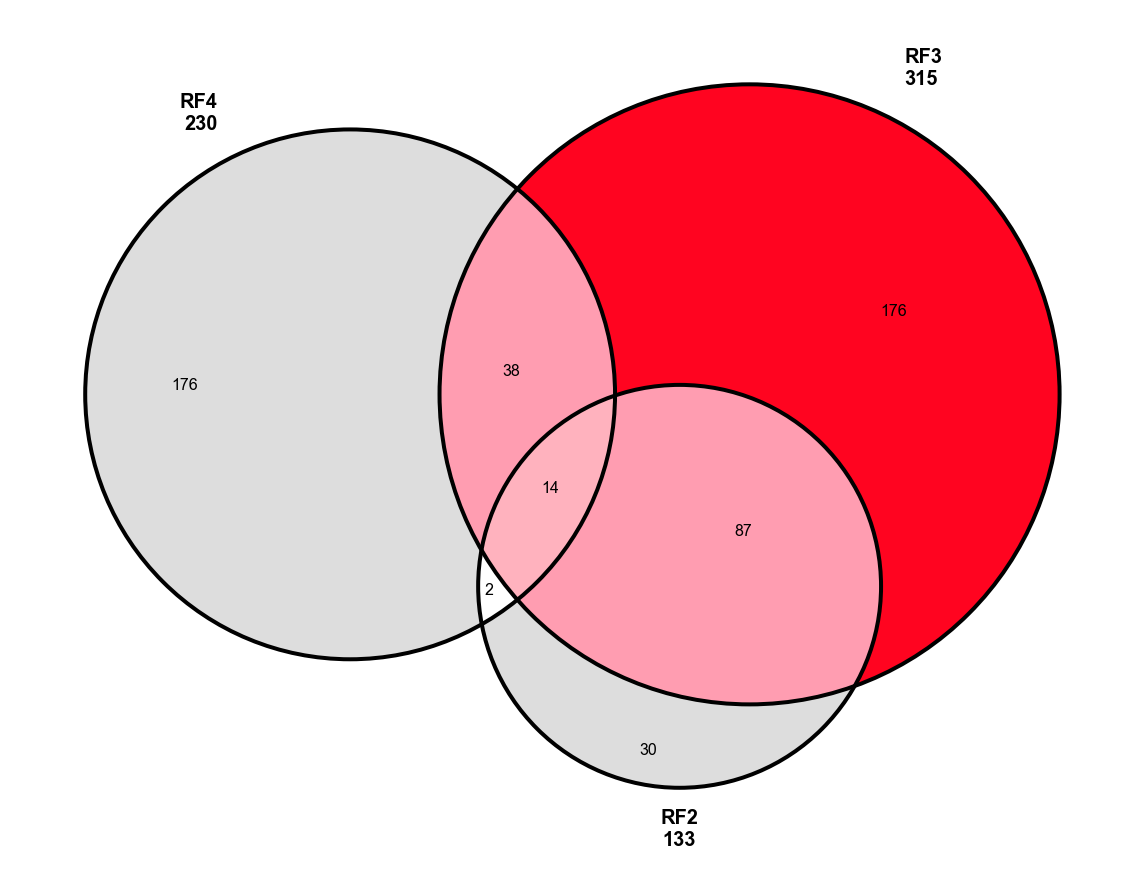

In [5]:
venn3_diagram(
    subsets=[
        set(collections['op-retrofunding-4']),
        set(collections['op-rpgf3']),
        set(collections['op-rpgf2'])
    ],
    labels=[
        f"RF4\n{len(collections['op-retrofunding-4'])}",
        f"RF3\n{len(collections['op-rpgf3'])}",
        f"RF2\n{len(collections['op-rpgf2'])}"
    ],
    colors=['#DDD', COLOR1, '#DDD']
)

## Part 2: Trends in developer activity before/after RF3

What has been the change in developer activity 6 months before and after Retro Funding 3?

1. All participants
2. By cohort
3. Compared to synthetic control group
4. By amount of funding received in RF3

In [6]:
# HELPER FUNCTIONS

def assign_6_month_interval(date):
    year = date.year
    month = date.month
    
    if 12 <= month or month <= 5:
        if month <= 5:
            interval_start = pd.Timestamp(year=year-1, month=12, day=1)
        else:
            interval_start = pd.Timestamp(year=year, month=12, day=1)
    else: 
        interval_start = pd.Timestamp(year=year, month=6, day=1)
    
    interval_end = interval_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
    return f'{interval_start.strftime("%Y-%m")} to {interval_end.strftime("%Y-%m")}'

def growth_rate(monthly_values):
    n = len(monthly_values) - 1
    years = n / 12
    start_value = monthly_values.iloc[0]
    end_value = monthly_values.iloc[-1]
    cagr = (end_value / start_value) ** (1 / years) - 1
    return cagr

def fulltime_active_devs(dev_days_with_commits):
    return (
        min(dev_days_with_commits/10, 1)
        if dev_days_with_commits > 1
        else 0
    )

In [7]:
# CREATE A FILTERED DATAFRAME OF 'FULLTIME ACTIVE DEVELOPERS' BY PROJECT

dev_df = DEV_ACTIVITY_BY_PROJECT.copy()
dev_df = dev_df[dev_df['bucket_month'] >= '2022-01-01']
dev_df['cohort'] = dev_df['project_id'].map(project_cohort_mapping)
dev_df['bucket_month'] = pd.to_datetime(dev_df['bucket_month'])
dev_df['project_name'] = dev_df['project_id'].map(projects)
dev_df['6_month_interval'] = dev_df['bucket_month'].apply(assign_6_month_interval)
dev_df['fulltime_active_dev'] = dev_df['num_days'].apply(fulltime_active_devs)
dev_df.dropna(inplace=True)
dev_df.head(2)

project_id bucket_month  \
0  BU4je0rBaW7jy0kU_JDLW7p-pDxaVCMu4loDmU7q35E=   2022-06-01   
1  6kF9vB0xEfun7IZv4f3exhhtPDzgzN-5G9MbCQrIKj0=   2022-06-01   

                               from_artifact_id  num_days  num_commits  \
0  xbttWR88pz2yB_2sfgYZZkmW5cmzmw058cjDVjlbBeI=        10           78   
1  H4cdyq_GPKt_bpNvhOUmSToWAqV0YhAZ4PmIQLhVgSw=         6           11   

              cohort project_name    6_month_interval  fulltime_active_dev  
0  Never received RF          w3c  2022-06 to 2022-11                  1.0  
1  Never received RF     bitquery  2022-06 to 2022-11                  0.6

Text(0.0, 1.0, 'Change in developer activity for projects in RF3\n')

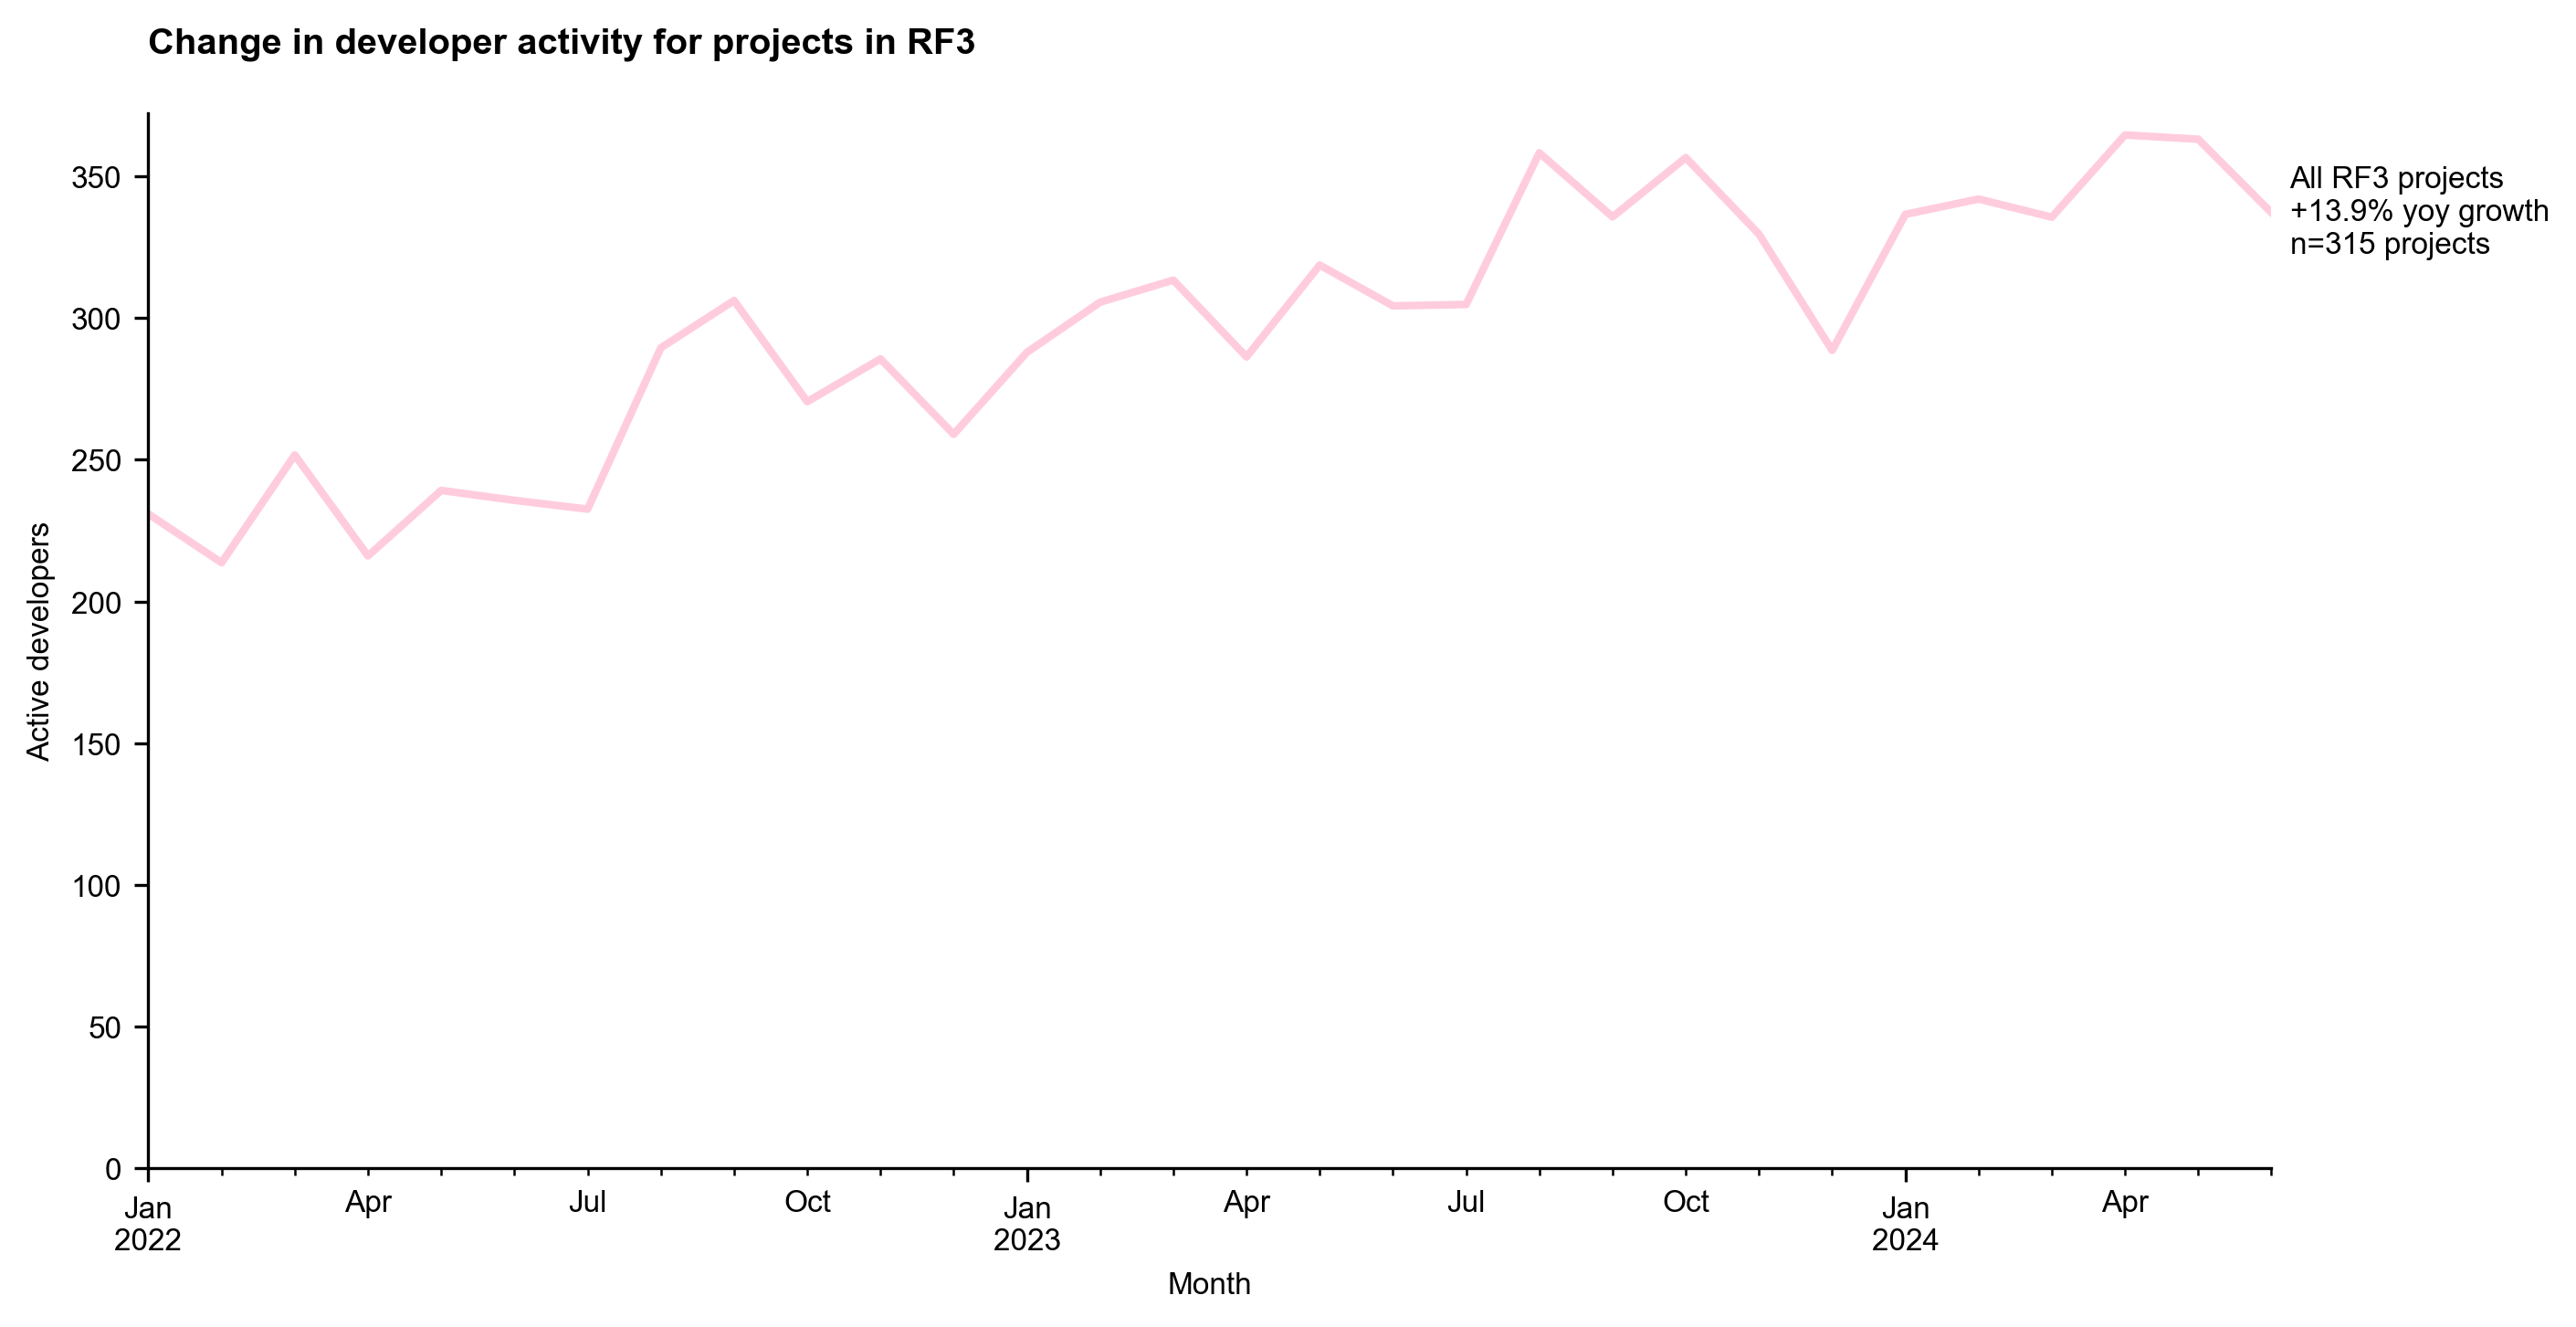

In [8]:
fig, ax = plt.subplots()
dev_dff = (
    dev_df[dev_df['project_id'].isin(collections['op-rpgf3'])]
    .groupby('bucket_month')['fulltime_active_dev']
    .sum()
)
dev_dff.plot(kind='line', color=COLOR3, lw=2, ax=ax)

label = 'All RF3 projects'
g = growth_rate(dev_dff[-14:-1])
n = len(collections['op-rpgf3'])
gstr = f"{g:+.1%}"
label = f"{label}\n{gstr} yoy growth\nn={n} projects"
xmax = ax.get_xlim()[-1] + .25
ax.text(x=xmax, y=dev_dff.iloc[-1], s=label, va='center', )

ax.set_ylim(0,)
ax.set_ylabel("Active developers")
ax.set_xlabel("Month")
ax.set_title("Change in developer activity for projects in RF3\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Change in developer activity for projects in RF3\n')

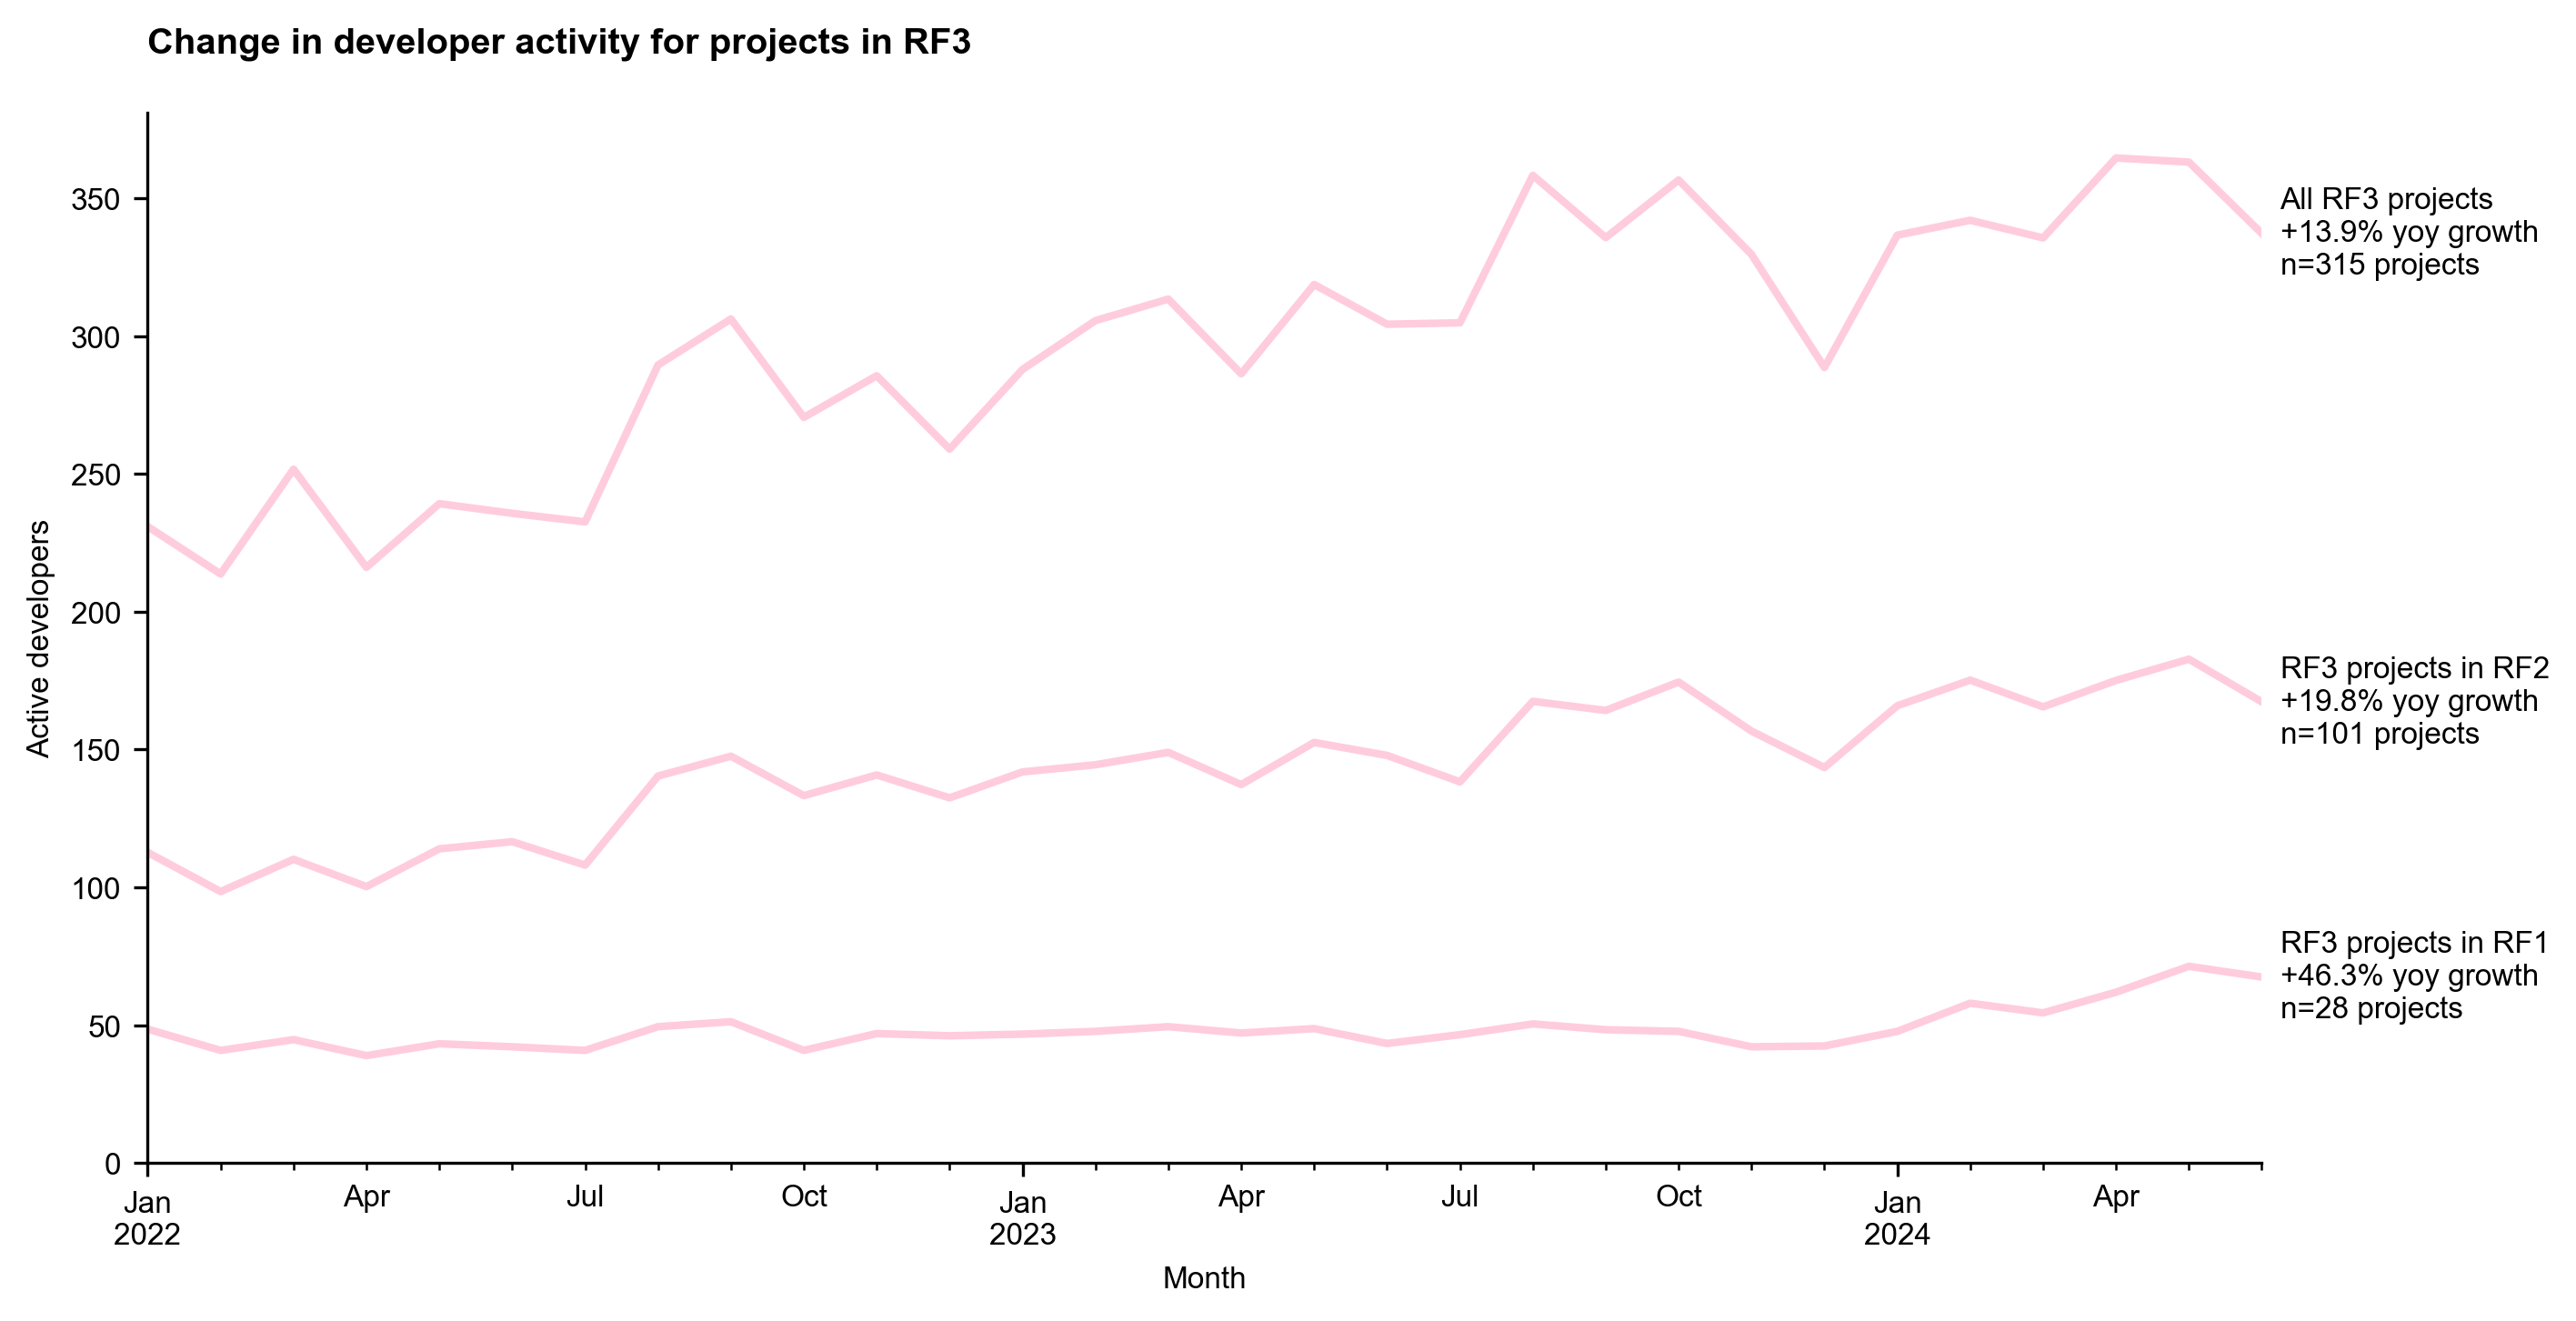

In [9]:
fig, ax = plt.subplots()
for collection in rf_collections:
    subcollection = set(collections.get(collection)).intersection(set(collections['op-rpgf3']))
    dev_dff = (
        dev_df[dev_df['project_id'].isin(subcollection)]
        .groupby('bucket_month')['fulltime_active_dev']
        .sum()
    )
    dev_dff.plot(kind='line', color=COLOR3, lw=2, ax=ax)
    
    label = 'All RF3 projects'
    if collection != 'op-rpgf3':
        label = f"RF3 projects in RF{collection[-1]}"
    g = growth_rate(dev_dff[-14:-1])
    n = len(subcollection)
    gstr = f"{g:+.1%}"
    label = f"{label}\n{gstr} yoy growth\nn={n} projects"
    xmax = ax.get_xlim()[-1] + .25
    ax.text(x=xmax, y=dev_dff.iloc[-1], s=label, va='center', )
    
ax.set_ylim(0,)
ax.set_ylabel("Active developers")
ax.set_xlabel("Month")
ax.set_title("Change in developer activity for projects in RF3\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Change in developer activity by cohort\n')

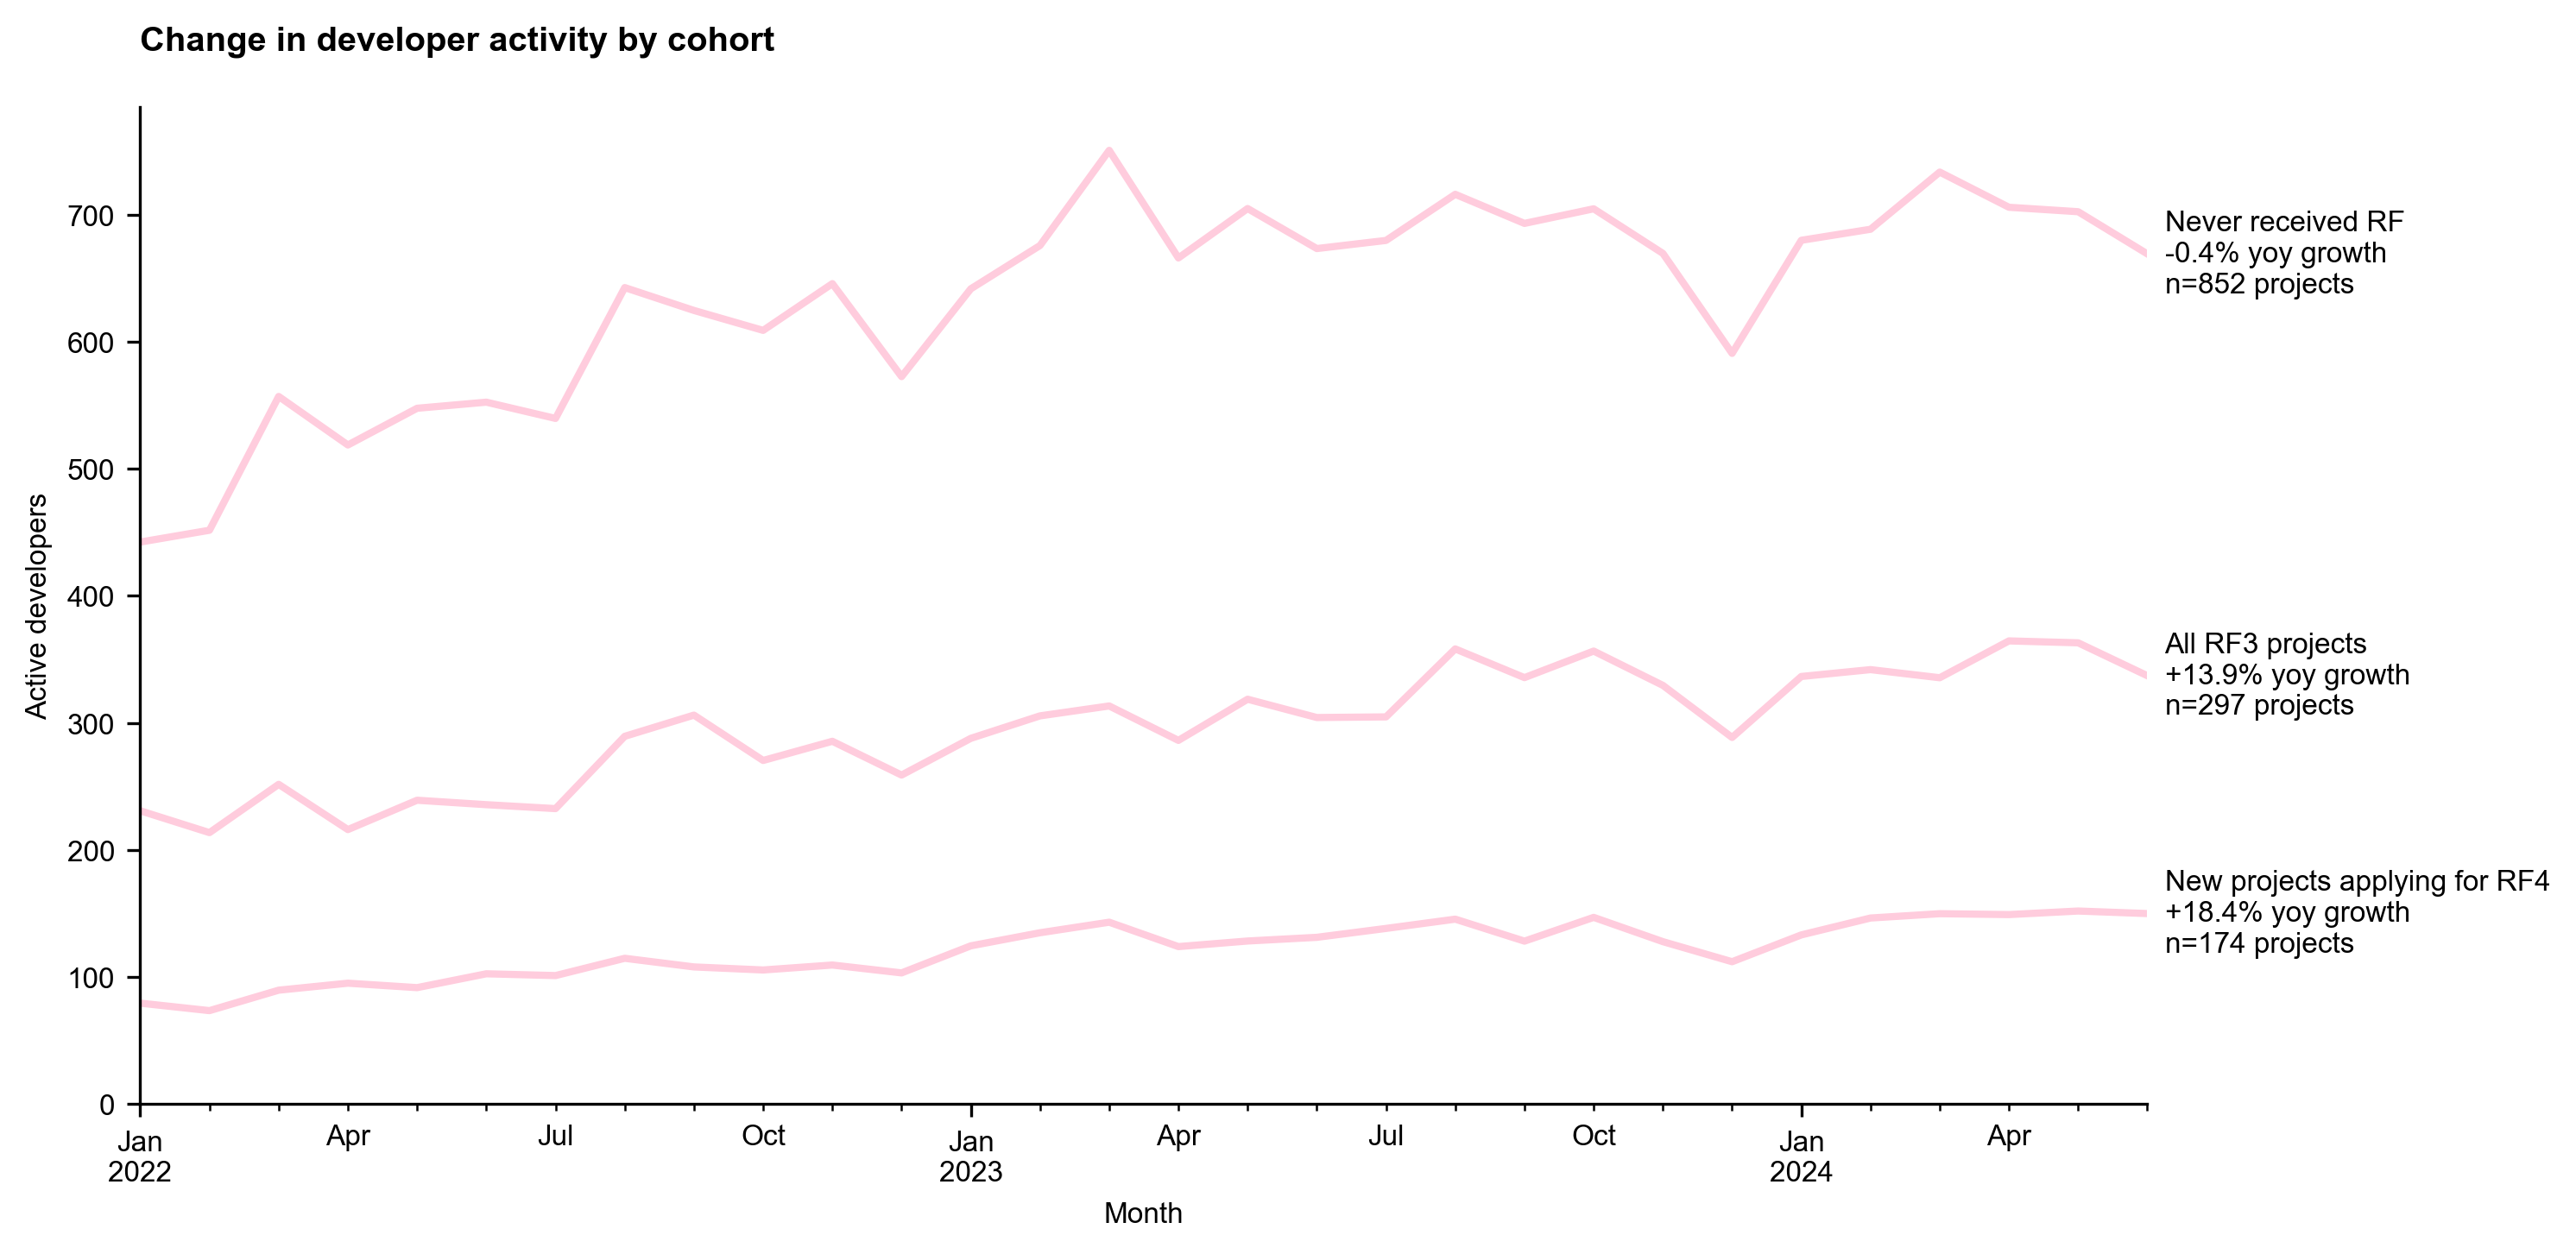

In [10]:
fig, ax = plt.subplots()
comps = [
    {
        'filter': dev_df[dev_df['project_id'].isin(collections['op-rpgf3'])],
        'label': 'All RF3 projects'
    },
    {
        'filter': dev_df[dev_df['cohort']=='Never received RF'],
        'label': 'Never received RF'
    },
    {
        'filter': dev_df[dev_df['cohort']=='First-time RF project'],
        'label': 'New projects applying for RF4'
    }
]
for comp in comps:
    dev_dff = comp['filter'].groupby('bucket_month')['fulltime_active_dev'].sum()
    dev_dff.plot(kind='line', color=COLOR3, lw=2, ax=ax)
    
    label = comp['label']
    g = growth_rate(dev_dff[-14:-1])
    n = comp['filter']['project_id'].nunique()
    gstr = f"{g:+.1%}"
    label = f"{label}\n{gstr} yoy growth\nn={n} projects"
    xmax = ax.get_xlim()[-1] + .25
    ax.text(x=xmax, y=dev_dff.iloc[-1], s=label, va='center', )
    
ax.set_ylim(0,)
ax.set_ylabel("Active developers")
ax.set_xlabel("Month")
ax.set_title("Change in developer activity by cohort\n", loc='left', weight='bold')

In [11]:
# CREATE A NEW COMPARISON FOR 6 MONTHS BEFORE/AFTER RF3

BEFORE = '2023-06 to 2023-11'
AFTER = '2023-12 to 2024-05'

delta_df = dev_df.pivot_table(
    index='project_id',
    columns='6_month_interval',
    values='fulltime_active_dev',
    aggfunc='sum',
    fill_value=0
)
delta_df = delta_df[delta_df[BEFORE] > 0]
delta_df['delta'] = delta_df[AFTER]/6 - delta_df[BEFORE]/6

delta_df['is_rf_project'] = ~delta_df.index.isin(cohorts['Never received RF'])
delta_df['project_name'] = delta_df.index.map(projects)

Text(0.0, 1.0, 'Comparison of monthly active developers by RF3 project 6 months before and after\n')

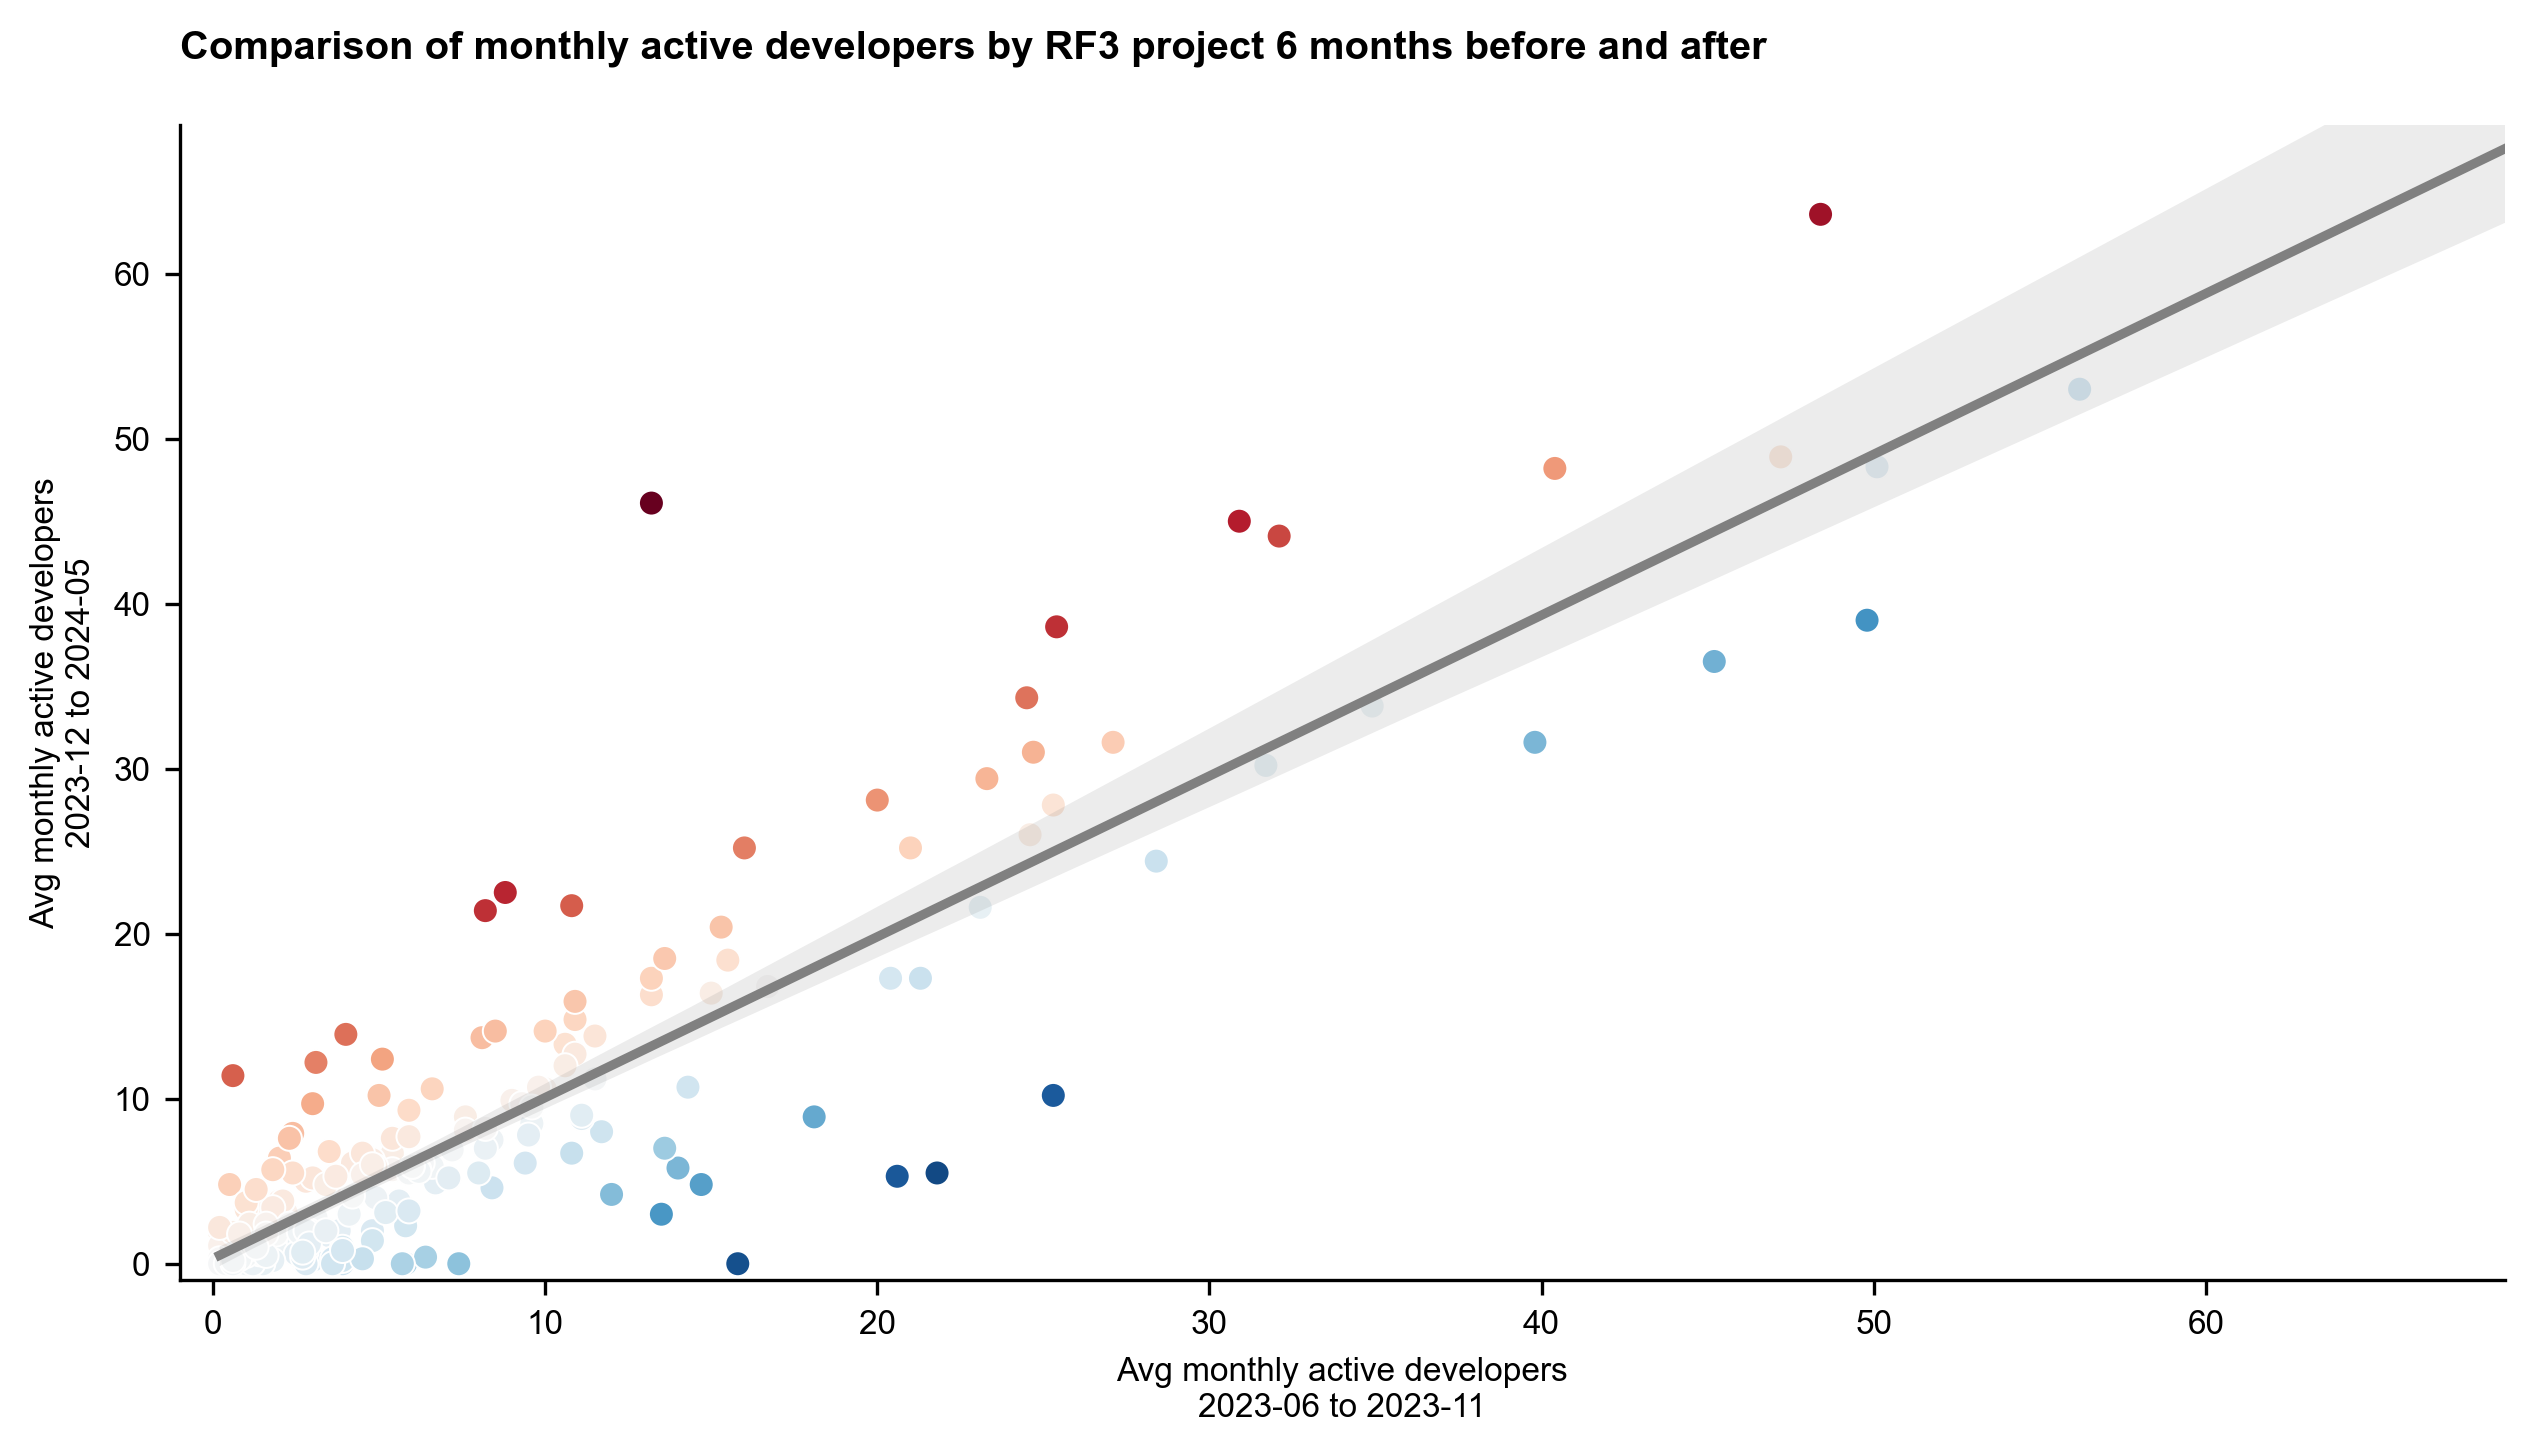

In [12]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=delta_df.reindex(collections['op-rpgf3']),
    x=BEFORE,
    y=AFTER,
    hue='delta',
    palette='RdBu_r',
    hue_norm=(-3,3),
    legend=False,
    ax=ax
)
sns.regplot(
    data=delta_df.reindex(collections['op-rpgf3']),
    x=BEFORE,
    y=AFTER,
    scatter=False,
    ax=ax,
    line_kws={'color': 'gray'}
)
ax.set_xlim(-1,69)
ax.set_ylim(-1,69)

ax.set_xlabel(f"Avg monthly active developers\n{BEFORE}")
ax.set_ylabel(f"Avg monthly active developers\n{AFTER}")
ax.set_title("Comparison of monthly active developers by RF3 project 6 months before and after\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Comparison of monthly active developers by project 6 months before and after RF3\n')

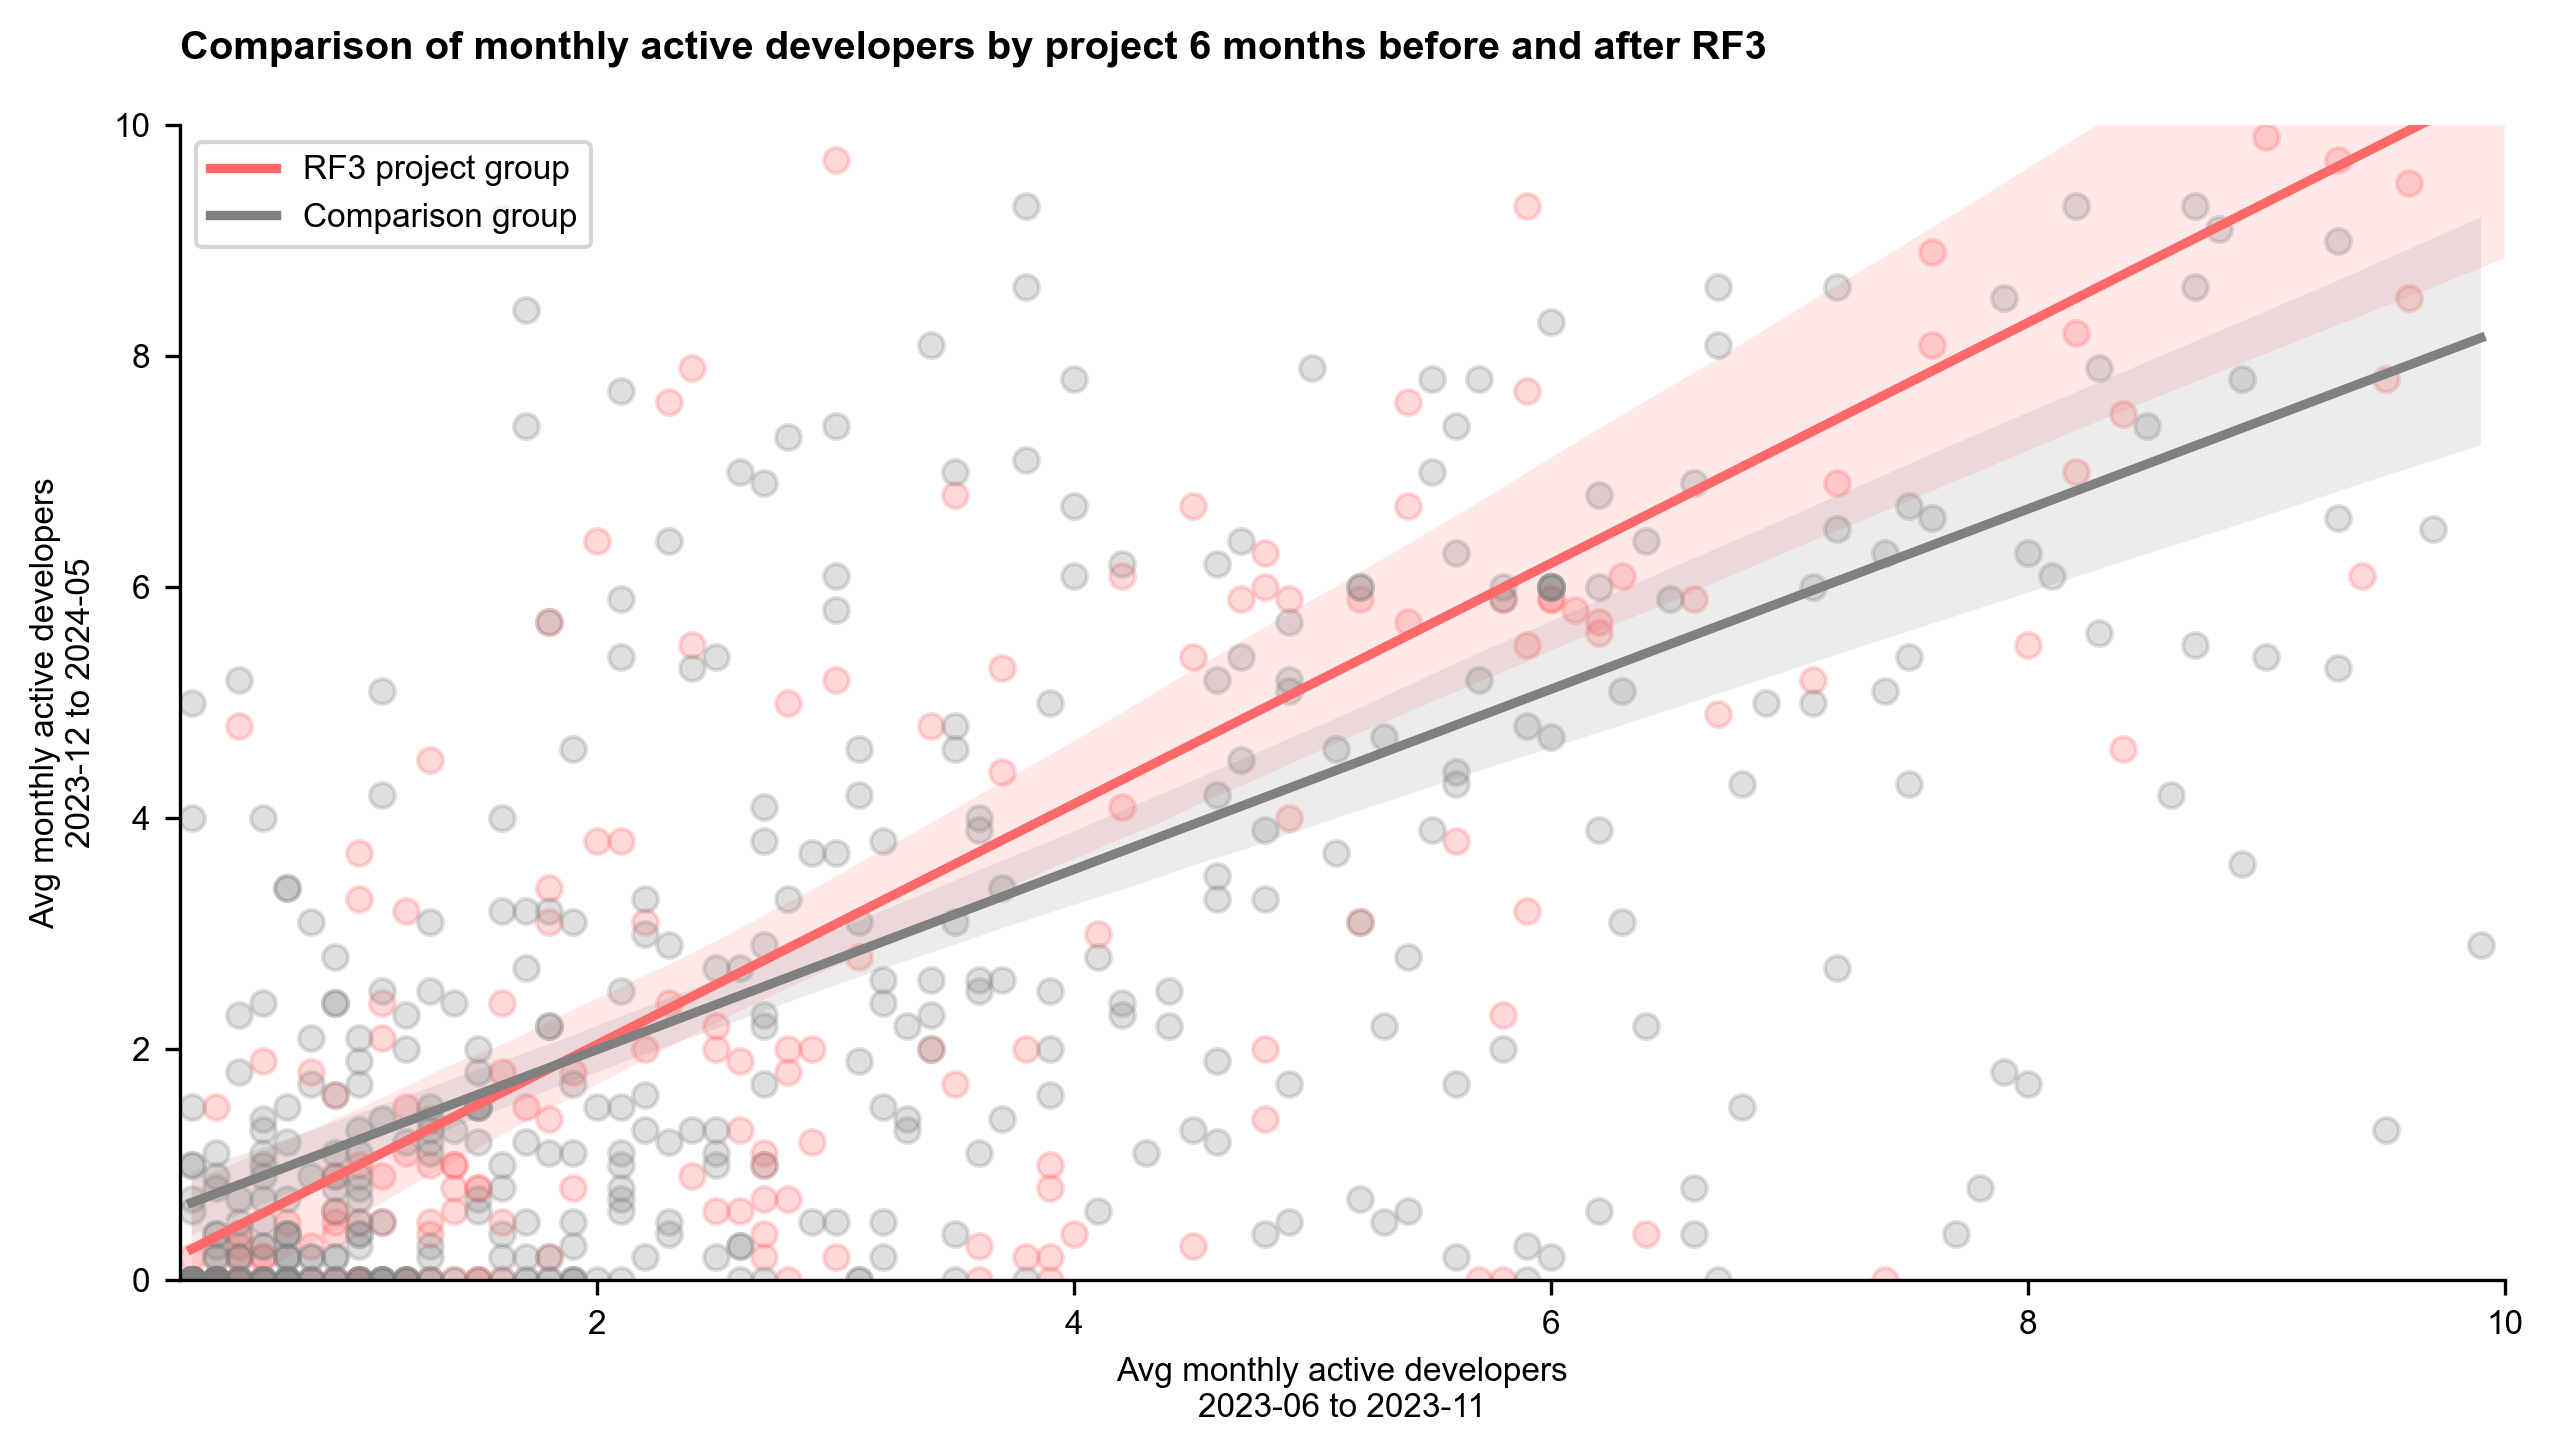

In [13]:
delta_dff = delta_df[delta_df[BEFORE].between(0.25,10)]
treatment = delta_dff[delta_dff.index.isin(collections['op-rpgf3'])]
control = delta_dff[delta_dff['is_rf_project']==False]

fig, ax = plt.subplots()
sns.regplot(
    data=treatment,
    x=BEFORE,
    y=AFTER,
    scatter=True,
    color=COLOR2,
    line_kws={'color': COLOR2, 'label': 'RF3 project group'},
    scatter_kws={'alpha': .25},
    ax=ax
)
sns.regplot(
    data=control,
    x=BEFORE,
    y=AFTER,
    scatter=True,
    color='gray',
    line_kws={'color': 'gray', 'label': 'Comparison group'},
    scatter_kws={'alpha': .25},
    ax=ax
)

ax.set_xlim(0.25,10)
ax.set_ylim(0,10)
ax.legend(loc='upper left')

ax.set_xlabel(f"Avg monthly active developers\n{BEFORE}")
ax.set_ylabel(f"Avg monthly active developers\n{AFTER}")
ax.set_title("Comparison of monthly active developers by project 6 months before and after RF3\n", loc='left', weight='bold')

5.133333333333336

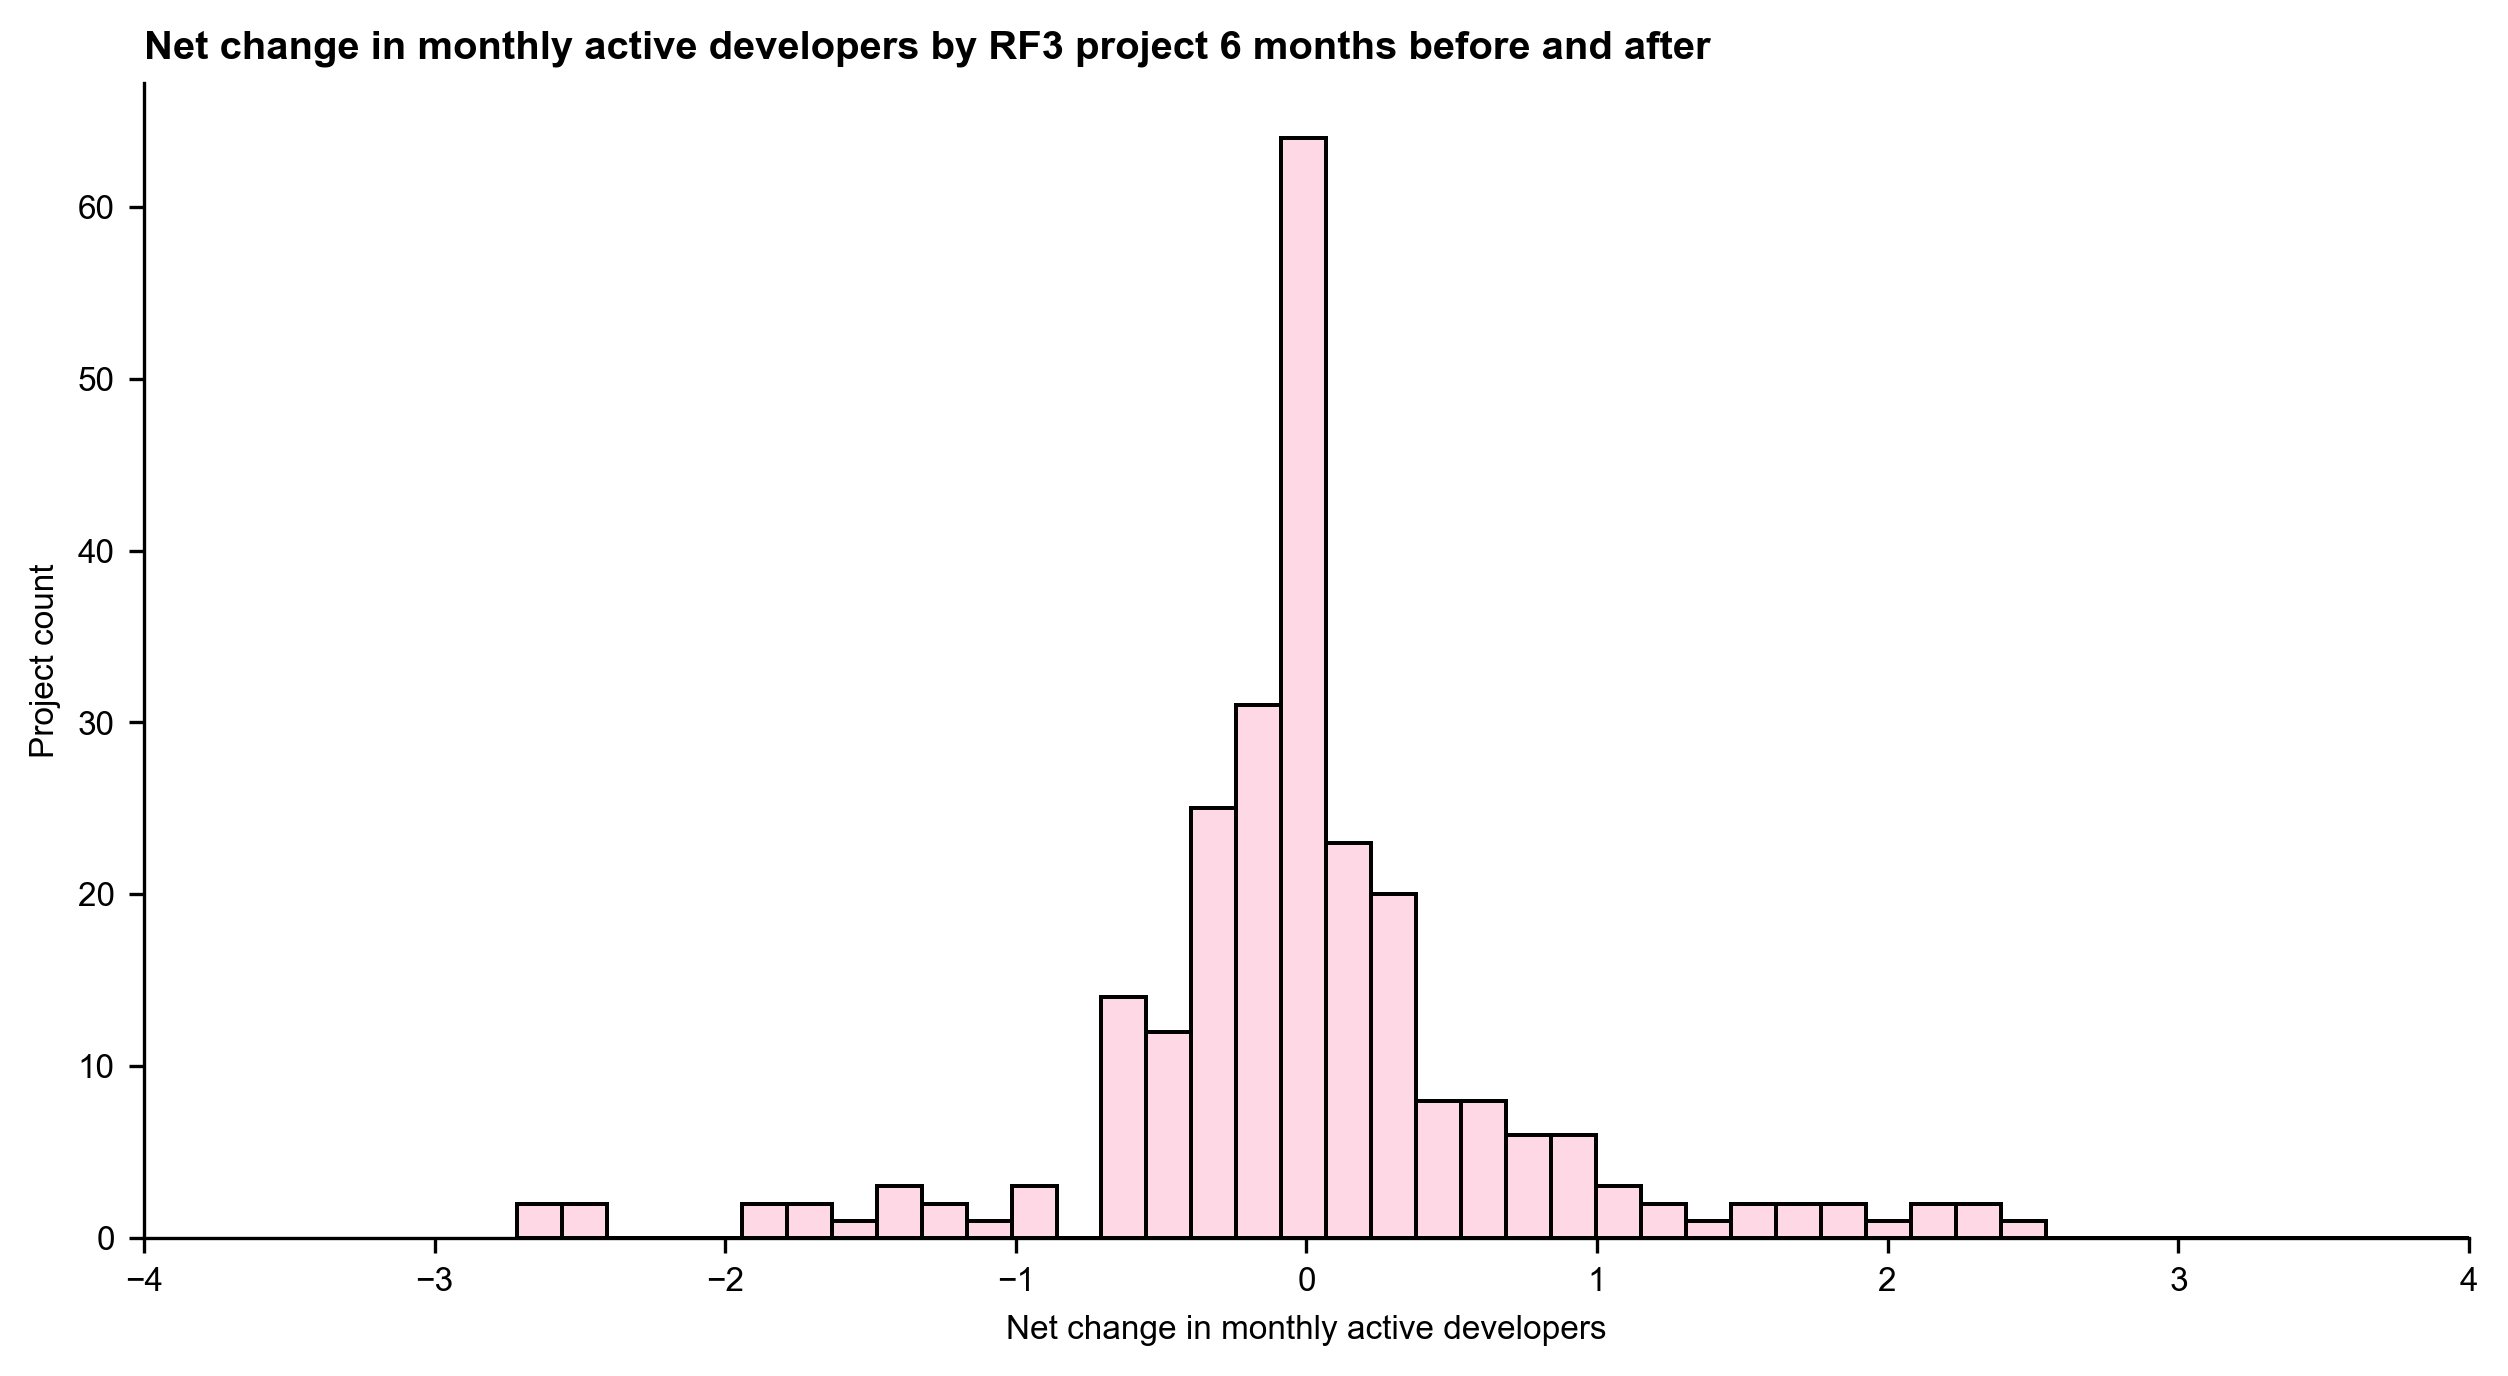

In [14]:
fig, ax = plt.subplots()
delta_values = delta_df.reindex(collections['op-rpgf3'])['delta'].dropna()
sns.histplot(delta_values, color=COLOR3, ax=ax)
ax.set_ylabel("Project count")
ax.set_xlabel("Net change in monthly active developers")
ax.set_title("Net change in monthly active developers by RF3 project 6 months before and after", loc='left', weight='bold')
ax.set_xlim(-4,4)
delta_values.sum()

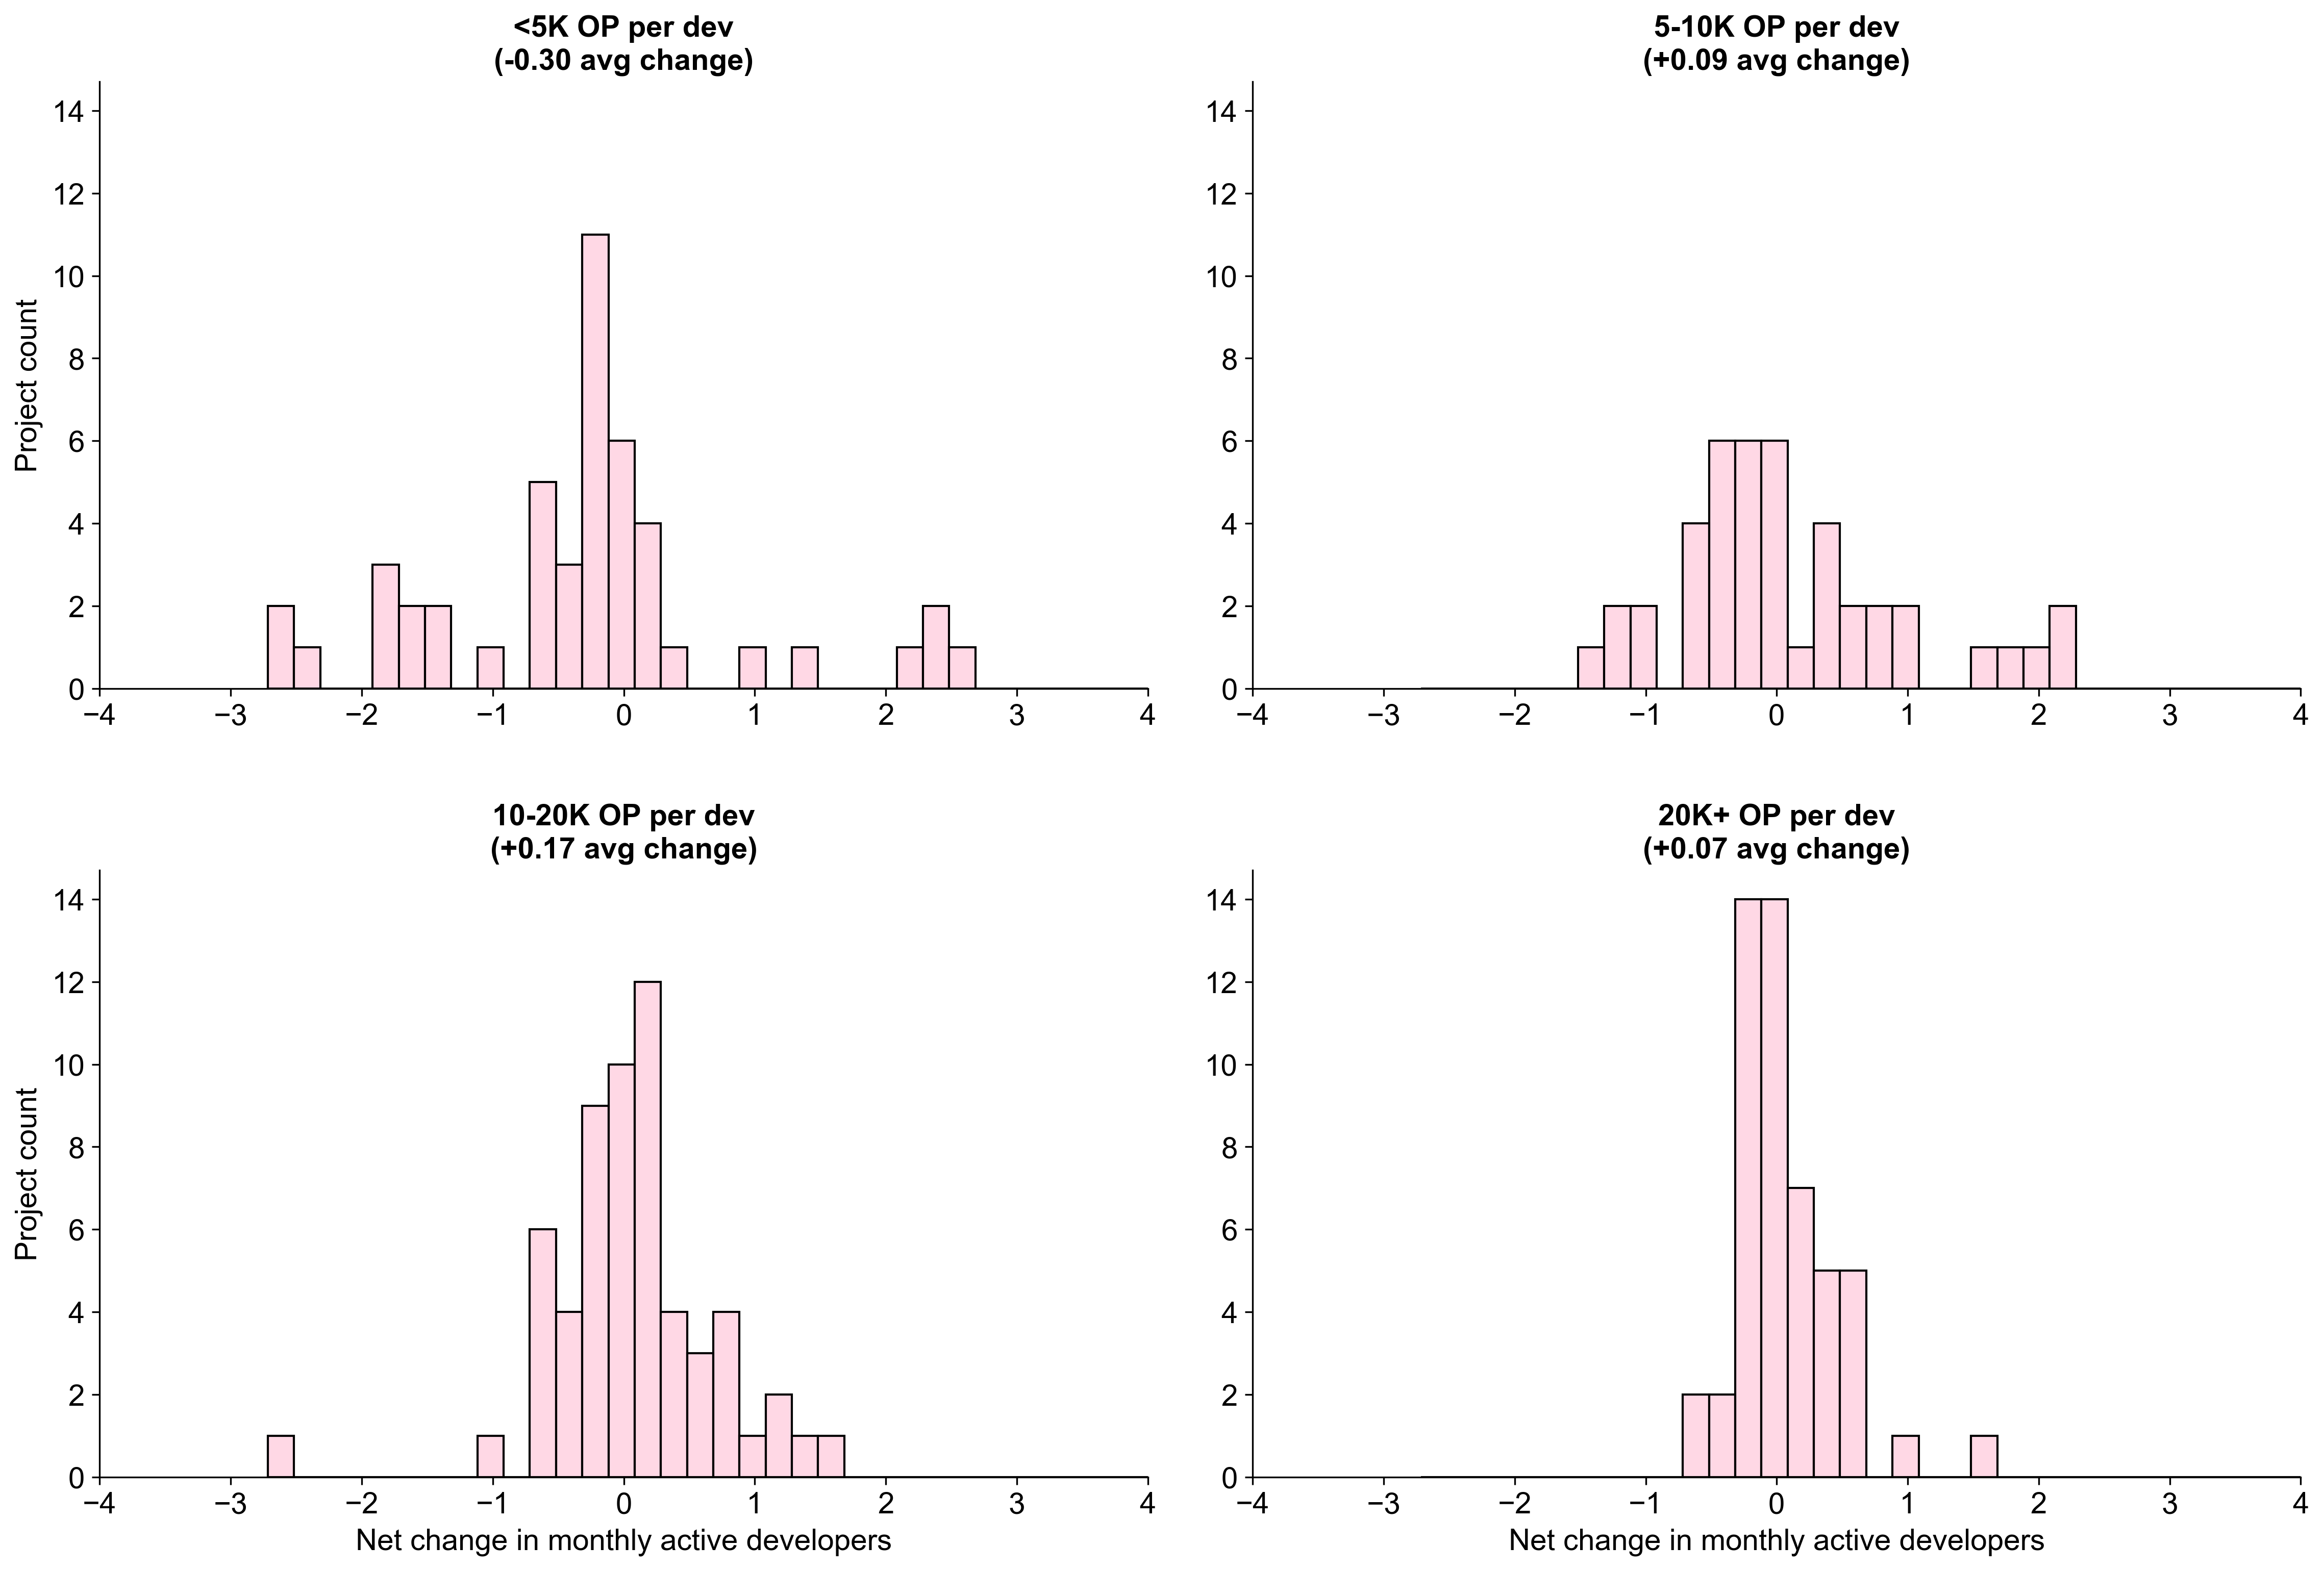

In [15]:
rf3_results = delta_df.set_index('project_name').join(RF3_RESULTS, how='right').dropna()
rf3_results = rf3_results[rf3_results[BEFORE] >= 1]

rf3_results['amount_per_dev'] = rf3_results['amount'] / rf3_results[BEFORE]
bins = [-float('inf'), 5000, 10000, 20000, float('inf')]
labels = ['<5K', '5-10K', '10-20K', '20K+']
rf3_results['amount_per_dev_category'] = pd.cut(rf3_results['amount_per_dev'], bins=bins, labels=labels)

vals = rf3_results.groupby('amount_per_dev_category')['delta'].mean()
rf3_results['amount_per_dev_category_label'] = rf3_results['amount_per_dev_category'].apply(
    lambda x: f"{x} OP per dev\n({vals.get(x):+.2f} avg change)"
)

g = sns.displot(
    data=rf3_results,
    x='delta',
    col='amount_per_dev_category_label',
    col_wrap=2,
    kind='hist',
    aspect=1.5,
    color=COLOR3,
)

font_size = 14
g.fig.subplots_adjust(hspace=0.3, wspace=.1)
g.set_titles(col_template="{col_name}", size=font_size, weight='bold')
g.set_axis_labels("Net change in monthly active developers", "Project count")

for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
    ax.set_xlim(-4,4)
    ax.set_ylabel(ax.get_ylabel(), fontsize=font_size)
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    ax.yaxis.set_tick_params(which='both', labelleft=True)

## Changes in onchain activity

What has been the change in onchain activity 6 months before and after Retro Funding 3?
1. Among RF4 applicants
2. By cohort
3. Compared to baseline

In [16]:
df_txns = TRANSACTIONS_BY_CHAIN.copy()
df_txns['bucket_day'] = pd.to_datetime(df_txns['bucket_day'].apply(lambda x: x.split()[0]))
superchain_networks = ['OPTIMISM', 'BASE', 'ZORA', 'MODE']
df_txns['network_label'] = df_txns['network'].apply(lambda x: 'SUPERCHAIN' if x in superchain_networks else x)
df_txns['project_name'] = df_txns['project_id'].map(projects)
df_txns['is_rf4'] = df_txns['project_id'].isin(collections['op-retrofunding-4'])
df_txns['cohort'] = df_txns['project_id'].map(project_cohort_mapping)
df_txns['cohort'].fillna('Unmapped', inplace=True)
df_txns['superchain'] = df_txns['network'].isin(superchain_networks)
df_txns['6_month_interval']= df_txns['bucket_day'].apply(assign_6_month_interval)
df_txns.tail()

bucket_day                                    project_id network  \
259020 2024-05-13  8RsppqhF6-tHDEnVATmtwf_fUMeOg6EsIn92GIR7NkI=    ZORA   
259021 2024-05-21  8RsppqhF6-tHDEnVATmtwf_fUMeOg6EsIn92GIR7NkI=    ZORA   
259022 2024-03-25  8RsppqhF6-tHDEnVATmtwf_fUMeOg6EsIn92GIR7NkI=    ZORA   
259023 2024-05-06  bCXvtpzVfkfzitw2N3LoqtlBfRmnpPb2CMVXZzgoK54=    ZORA   
259024 2024-01-23  jhbwVCWNelyiMntcZPWGmOgRl7buxEMIdgPhfvT0LPk=    ZORA   

        num_txns network_label project_name  is_rf4                 cohort  \
259020      2186    SUPERCHAIN    rubyscore    True  First-time RF project   
259021      2454    SUPERCHAIN    rubyscore    True  First-time RF project   
259022        74    SUPERCHAIN    rubyscore    True  First-time RF project   
259023        26    SUPERCHAIN          NaN   False               Unmapped   
259024        14    SUPERCHAIN   pods-media    True  First-time RF project   

        superchain    6_month_interval  
259020        True  2023-12 to 2024-05  
259021        True  2023-12 to 2024-05  
259022        True  2023-12 to 2024-05  
259023        True  2023-12 to 2024-05  
259024        True  2023-12 to 2024-05

Text(0.0, 1.0, 'Daily transactions for projects in RF4\n')

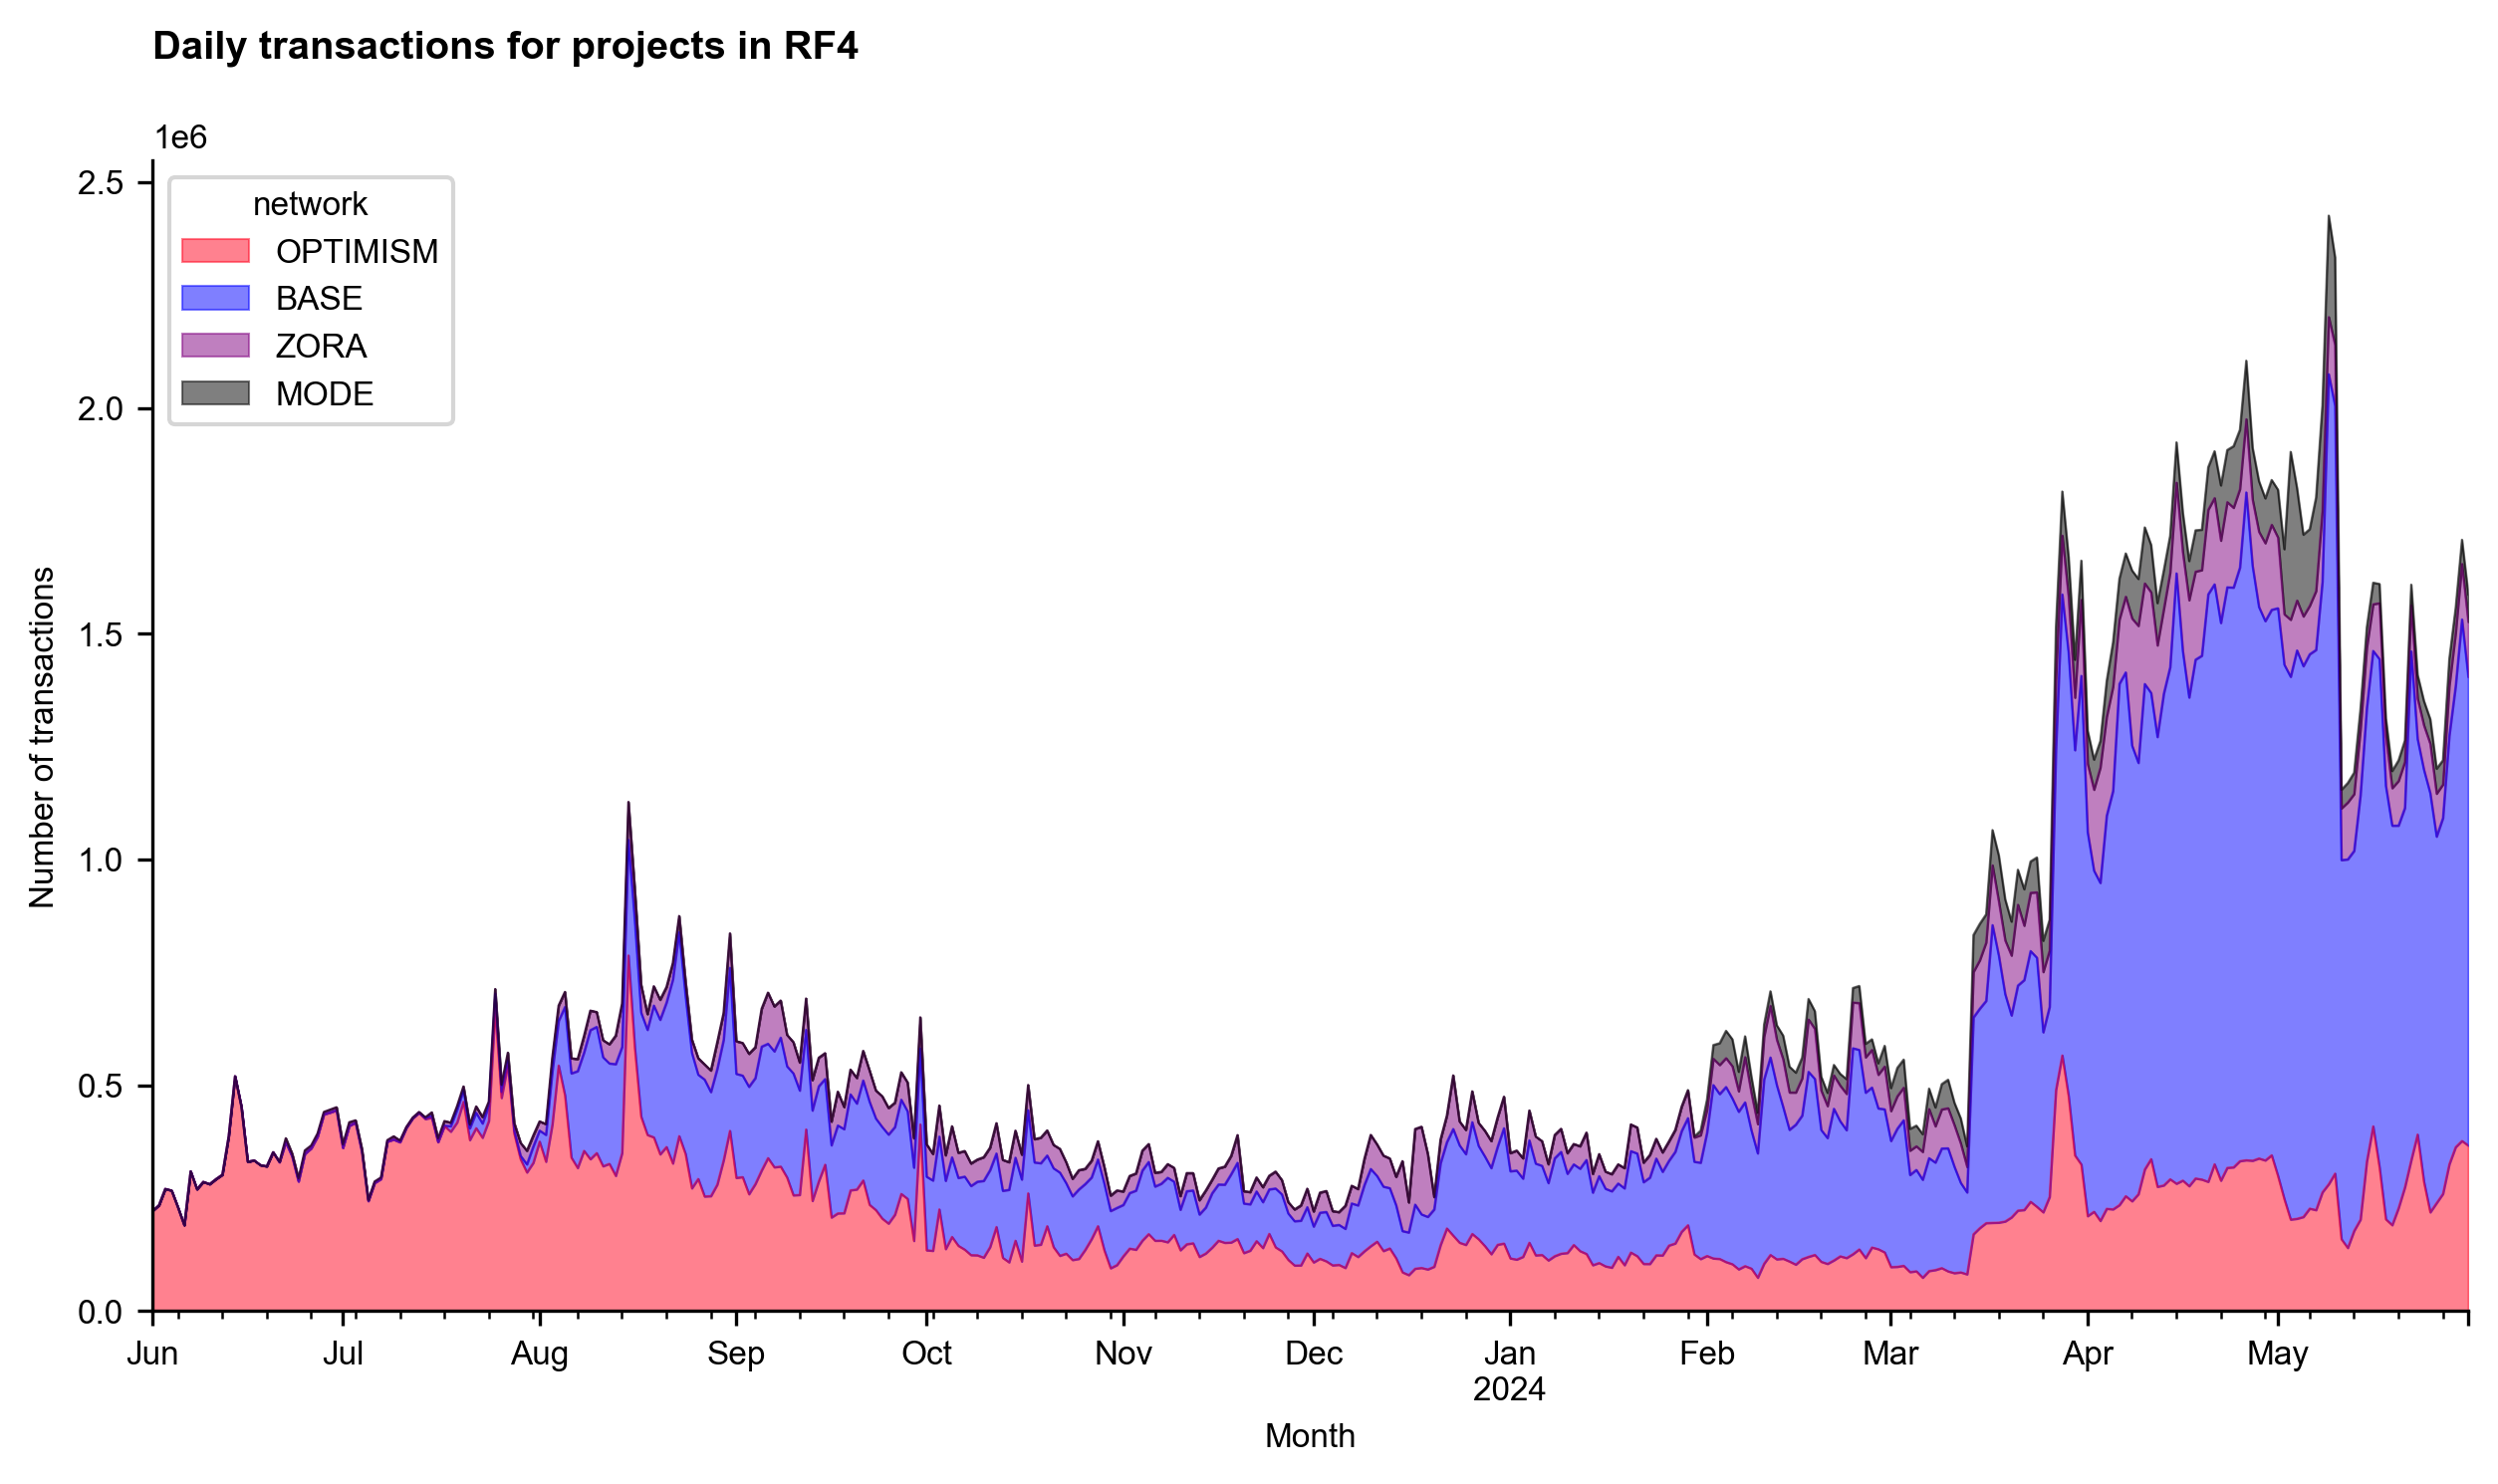

In [17]:
fig, ax = plt.subplots()

txns_pvt = (
    df_txns[(df_txns['is_rf4']) & (df_txns['network'].isin(superchain_networks))]
    .pivot_table(
        index='bucket_day',
        columns='network',
        values='num_txns',
        aggfunc='sum',
        fill_value=0
    )
    [superchain_networks]
)
txns_pvt.plot(
    kind='area', 
    color=[COLOR1, 'blue', 'purple', 'black'],
    alpha=.5,
    lw=.5,
    ax=ax
)
ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("Month")
ax.set_title("Daily transactions for projects in RF4\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Daily transactions for projects in RF4 by cohort\n')

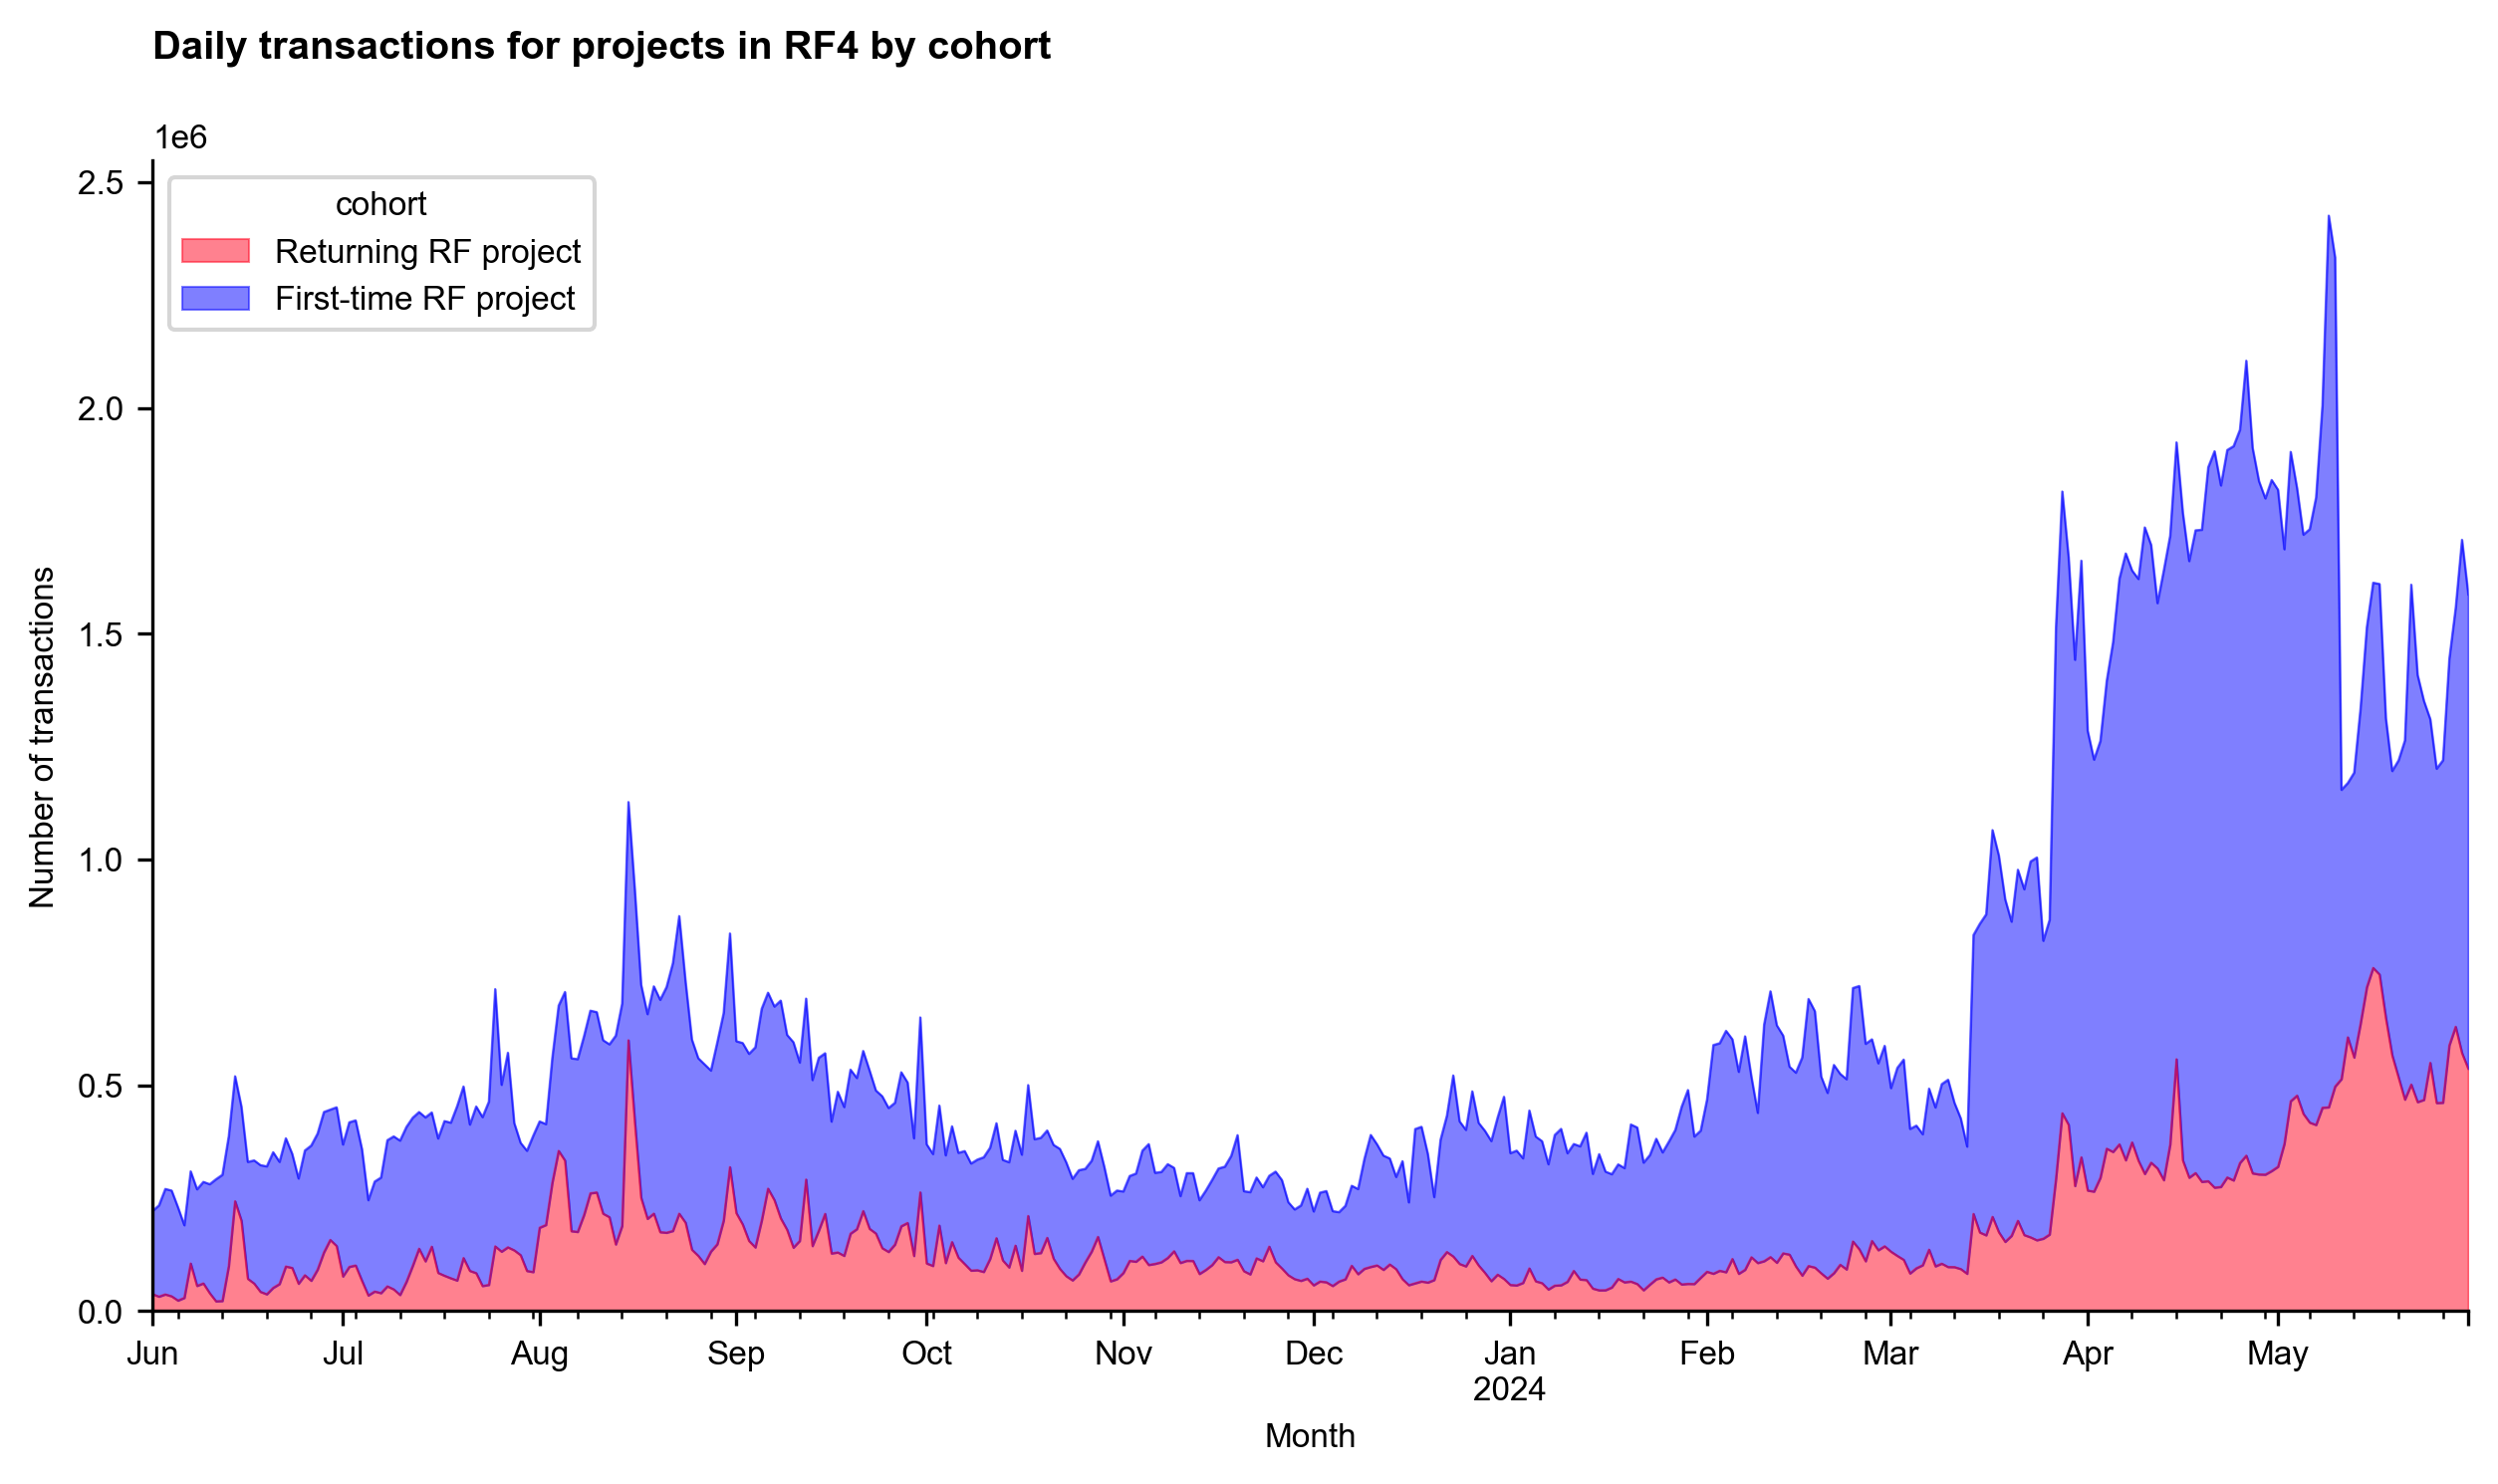

In [18]:
fig, ax = plt.subplots()

txns_pvt = (
    df_txns[(df_txns['is_rf4']) & (df_txns['network'].isin(superchain_networks))]
    .pivot_table(
        index='bucket_day',
        columns='cohort',
        values='num_txns',
        aggfunc='sum',
        fill_value=0
    )
    [['Returning RF project', 'First-time RF project']]
)
txns_pvt.plot(
    kind='area', 
    color=[COLOR1, 'blue'],
    alpha=.5,
    lw=.5,
    ax=ax
)
ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("Month")
ax.set_title("Daily transactions for projects in RF4 by cohort\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Daily transactions for projects in RF4 by cohort, including past recipients\n')

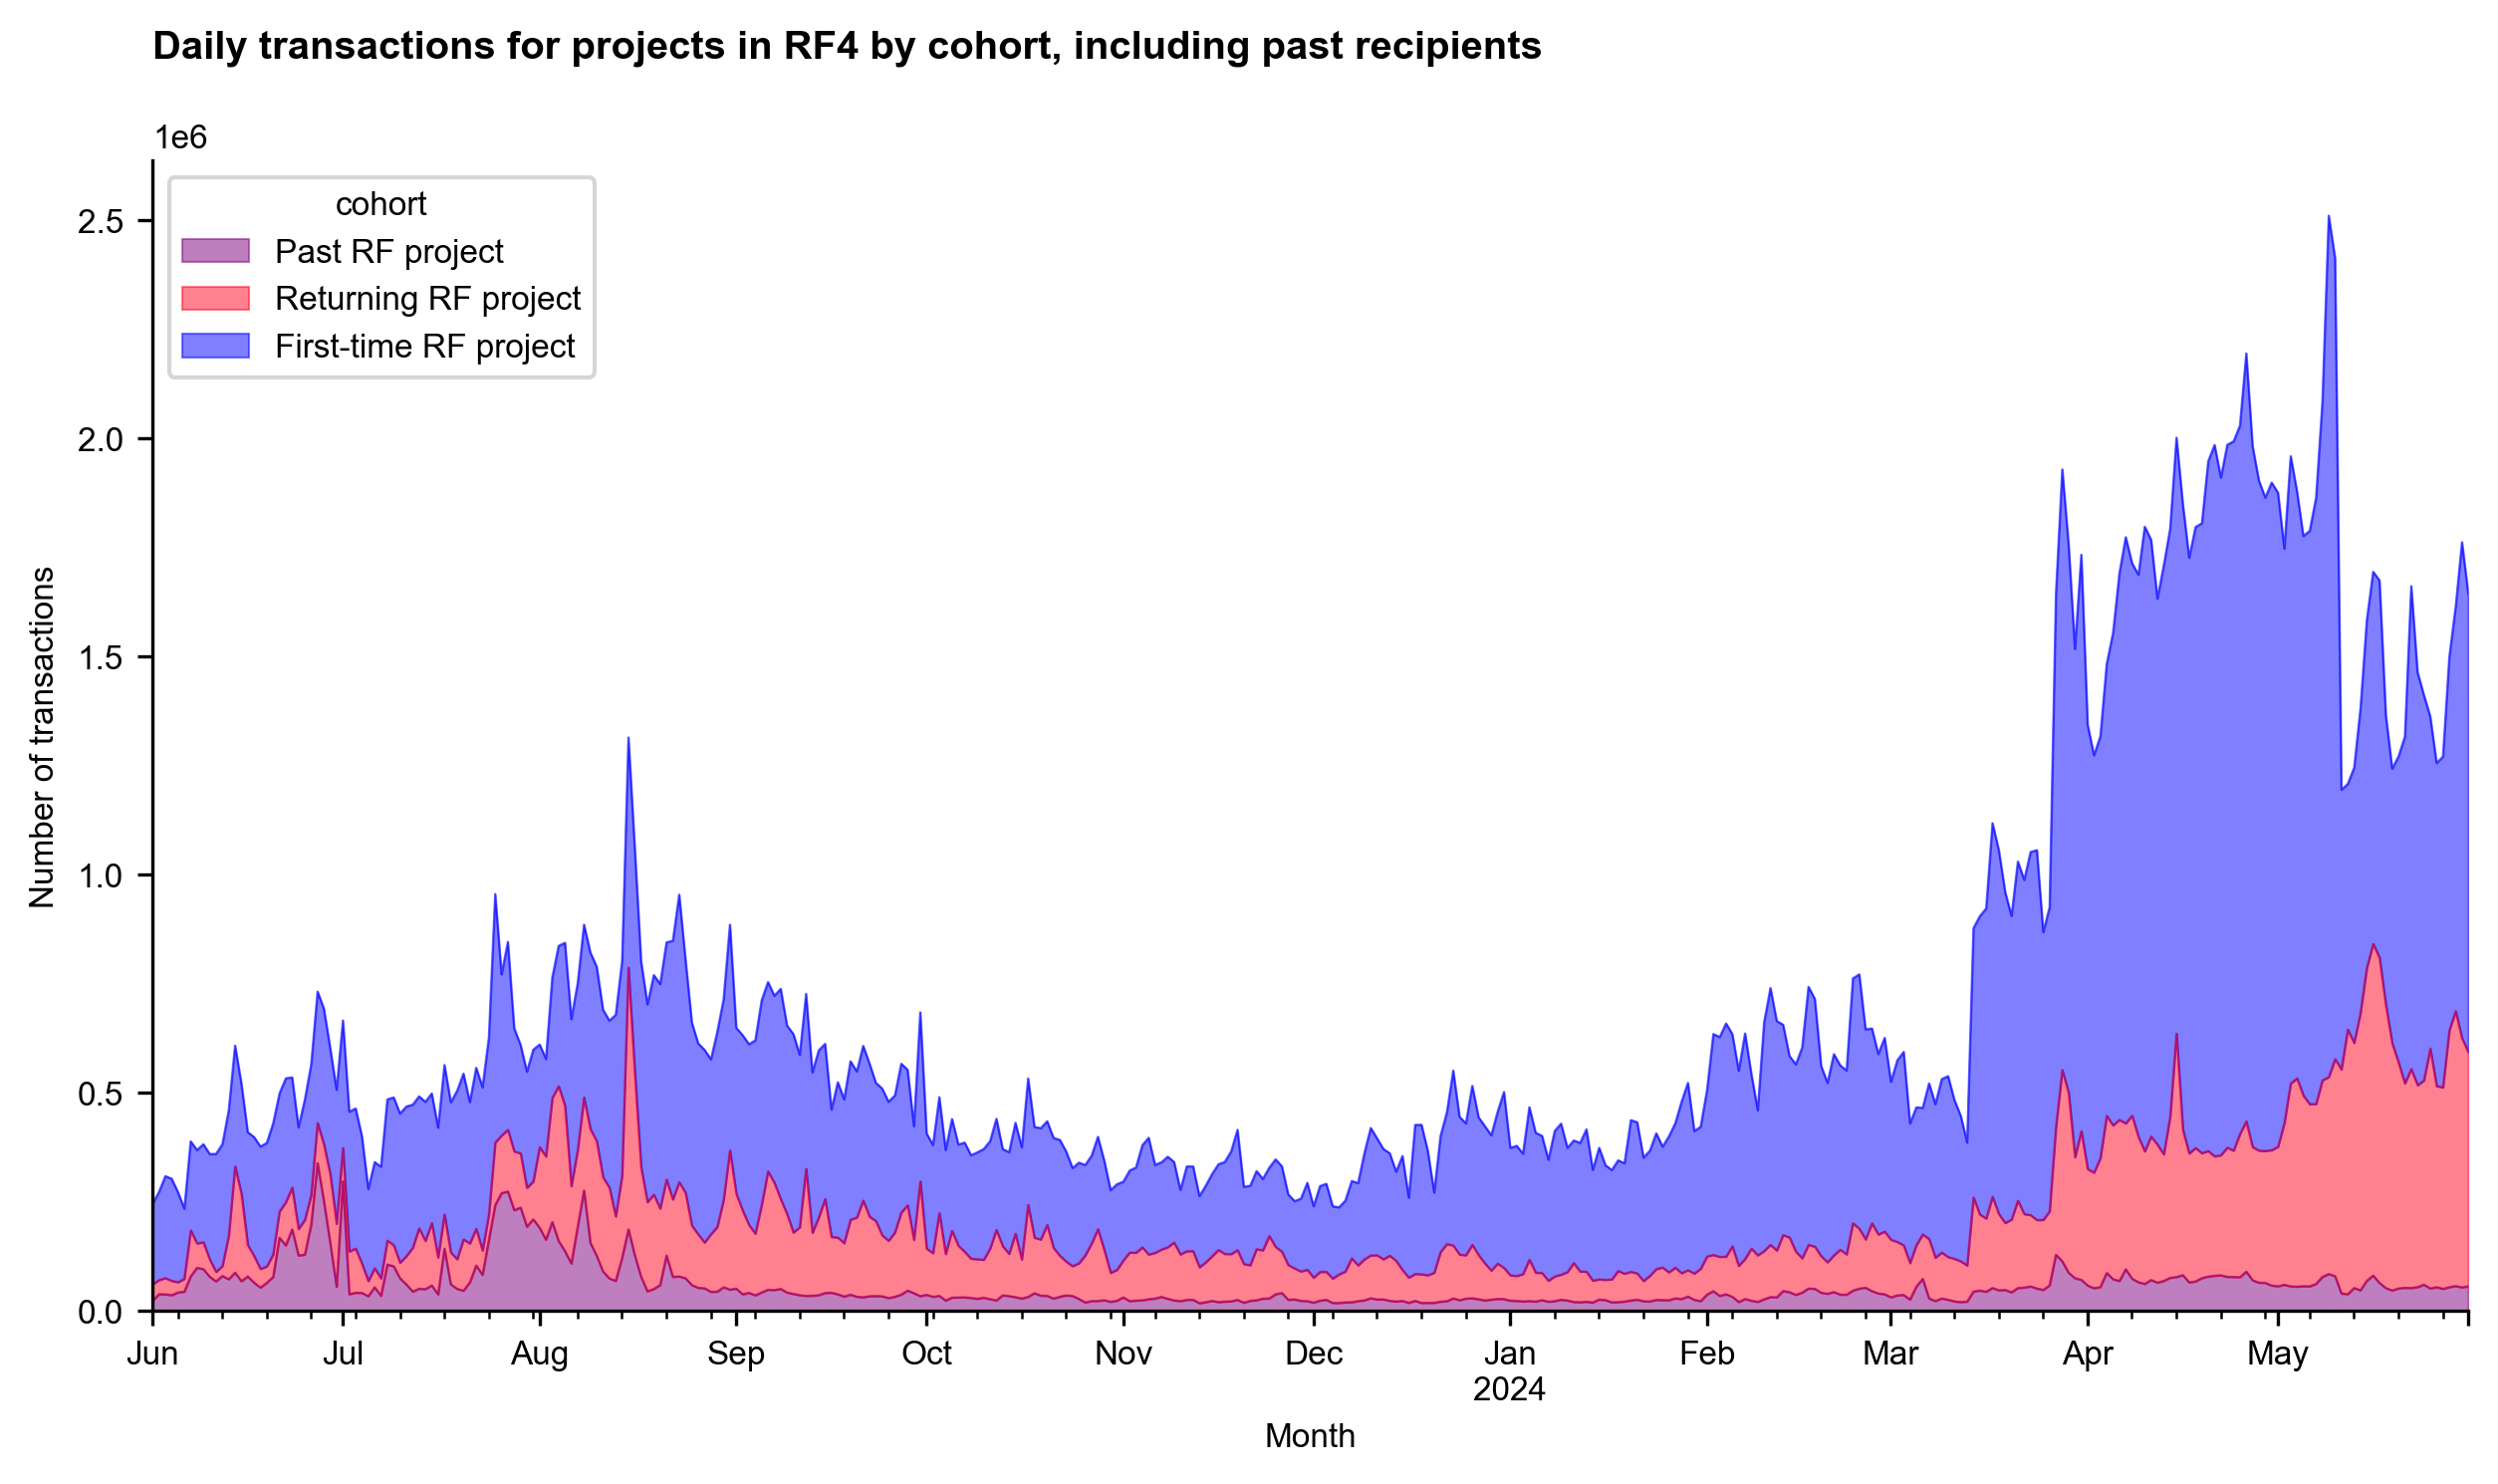

In [19]:
fig, ax = plt.subplots()

txns_pvt = (
    df_txns[df_txns['network'].isin(superchain_networks)]
    .pivot_table(
        index='bucket_day',
        columns='cohort',
        values='num_txns',
        aggfunc='sum',
        fill_value=0
    )
    [['Past RF project', 'Returning RF project', 'First-time RF project']]
)
txns_pvt.plot(
    kind='area', 
    color=['purple', COLOR1, 'blue'],
    alpha=.5,
    lw=.5,
    ax=ax
)
ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("Month")
ax.set_title("Daily transactions for projects in RF4 by cohort, including past recipients\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Daily transactions for projects in RF4 vs rest of Superchain\n')

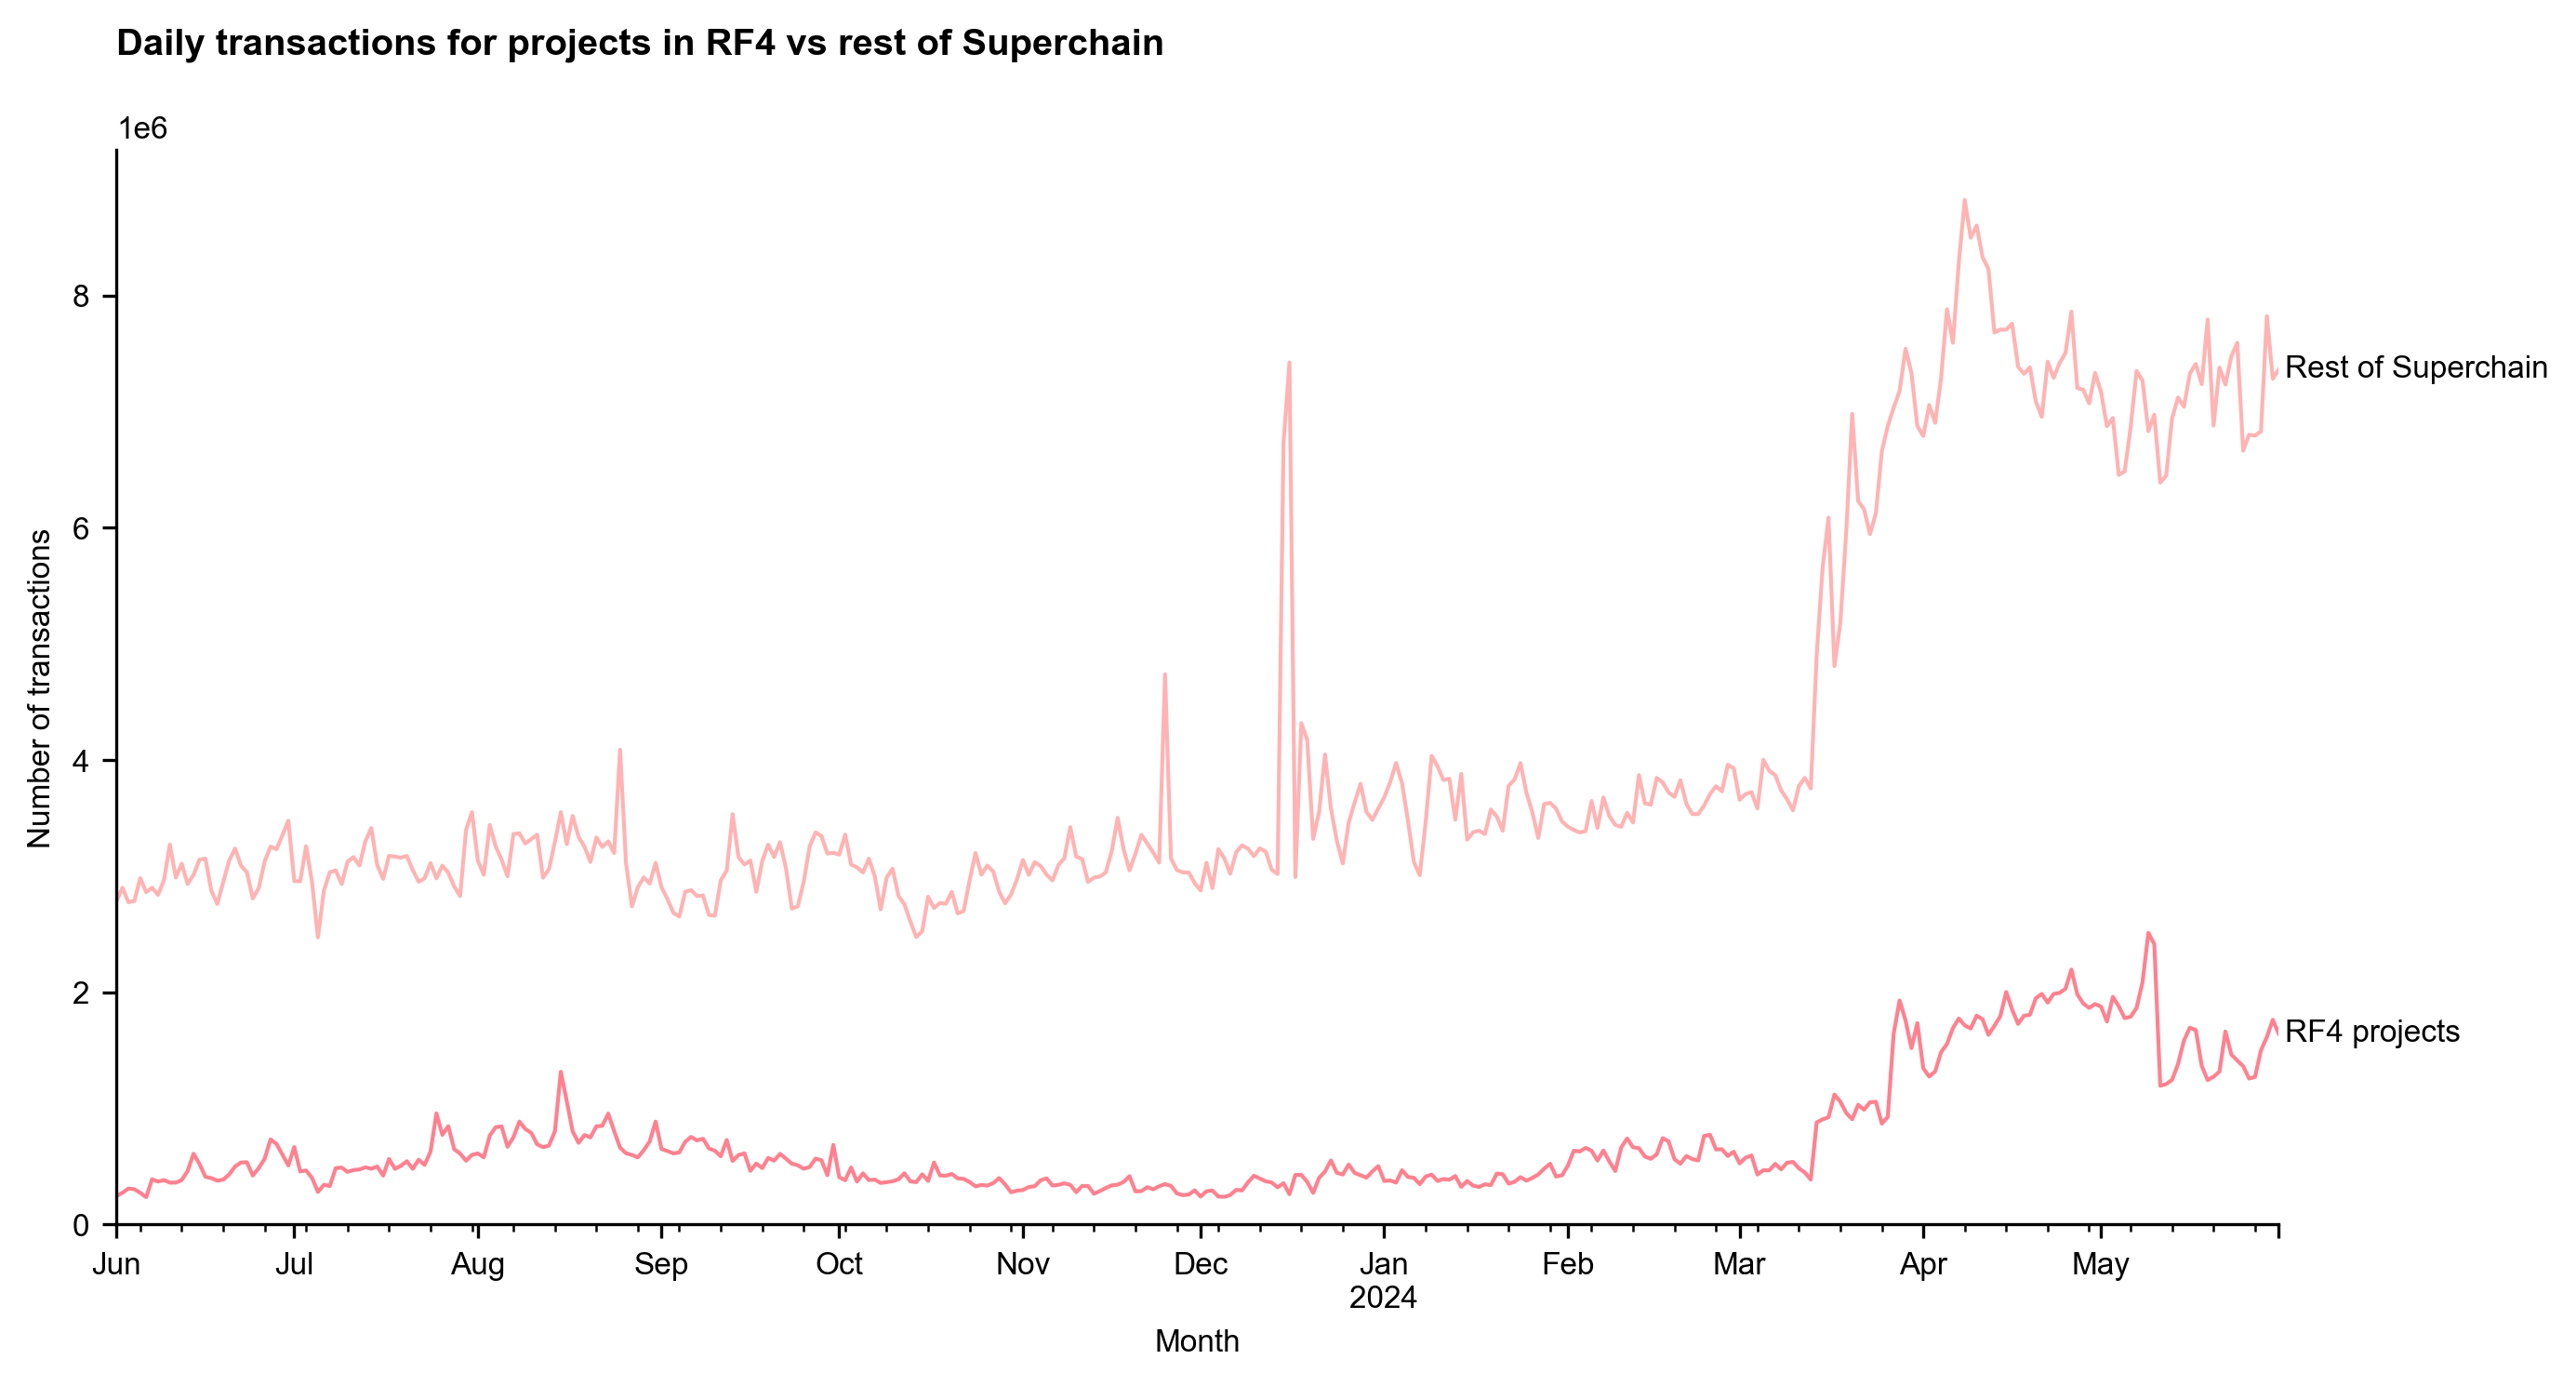

In [20]:
fig, ax = plt.subplots()

rf4_txns = (
    df_txns[(df_txns['network'].isin(superchain_networks)) & df_txns['project_id'].isin(rf_projects)==True]
    .groupby('bucket_day')['num_txns'].sum()
)
rf4_txns.plot(kind='line', color=COLOR1, alpha=.5, lw=1, ax=ax)

other_txns = (
    df_txns[(df_txns['network'].isin(superchain_networks)) & df_txns['project_id'].isin(rf_projects)==False]
    .groupby('bucket_day')['num_txns'].sum()
)
other_txns.plot(kind='line', color=COLOR2, alpha=.5, lw=1, ax=ax)

xmax = ax.get_xlim()[-1]
ax.text(x=xmax+1, y=rf4_txns.iloc[-1], s="RF4 projects", va='center')
ax.text(x=xmax+1, y=other_txns.iloc[-1], s="Rest of Superchain", va='center')

ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("Month")
ax.set_title("Daily transactions for projects in RF4 vs rest of Superchain\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Ratio of transactions from projects in RF4 to rest of Superchain\n')

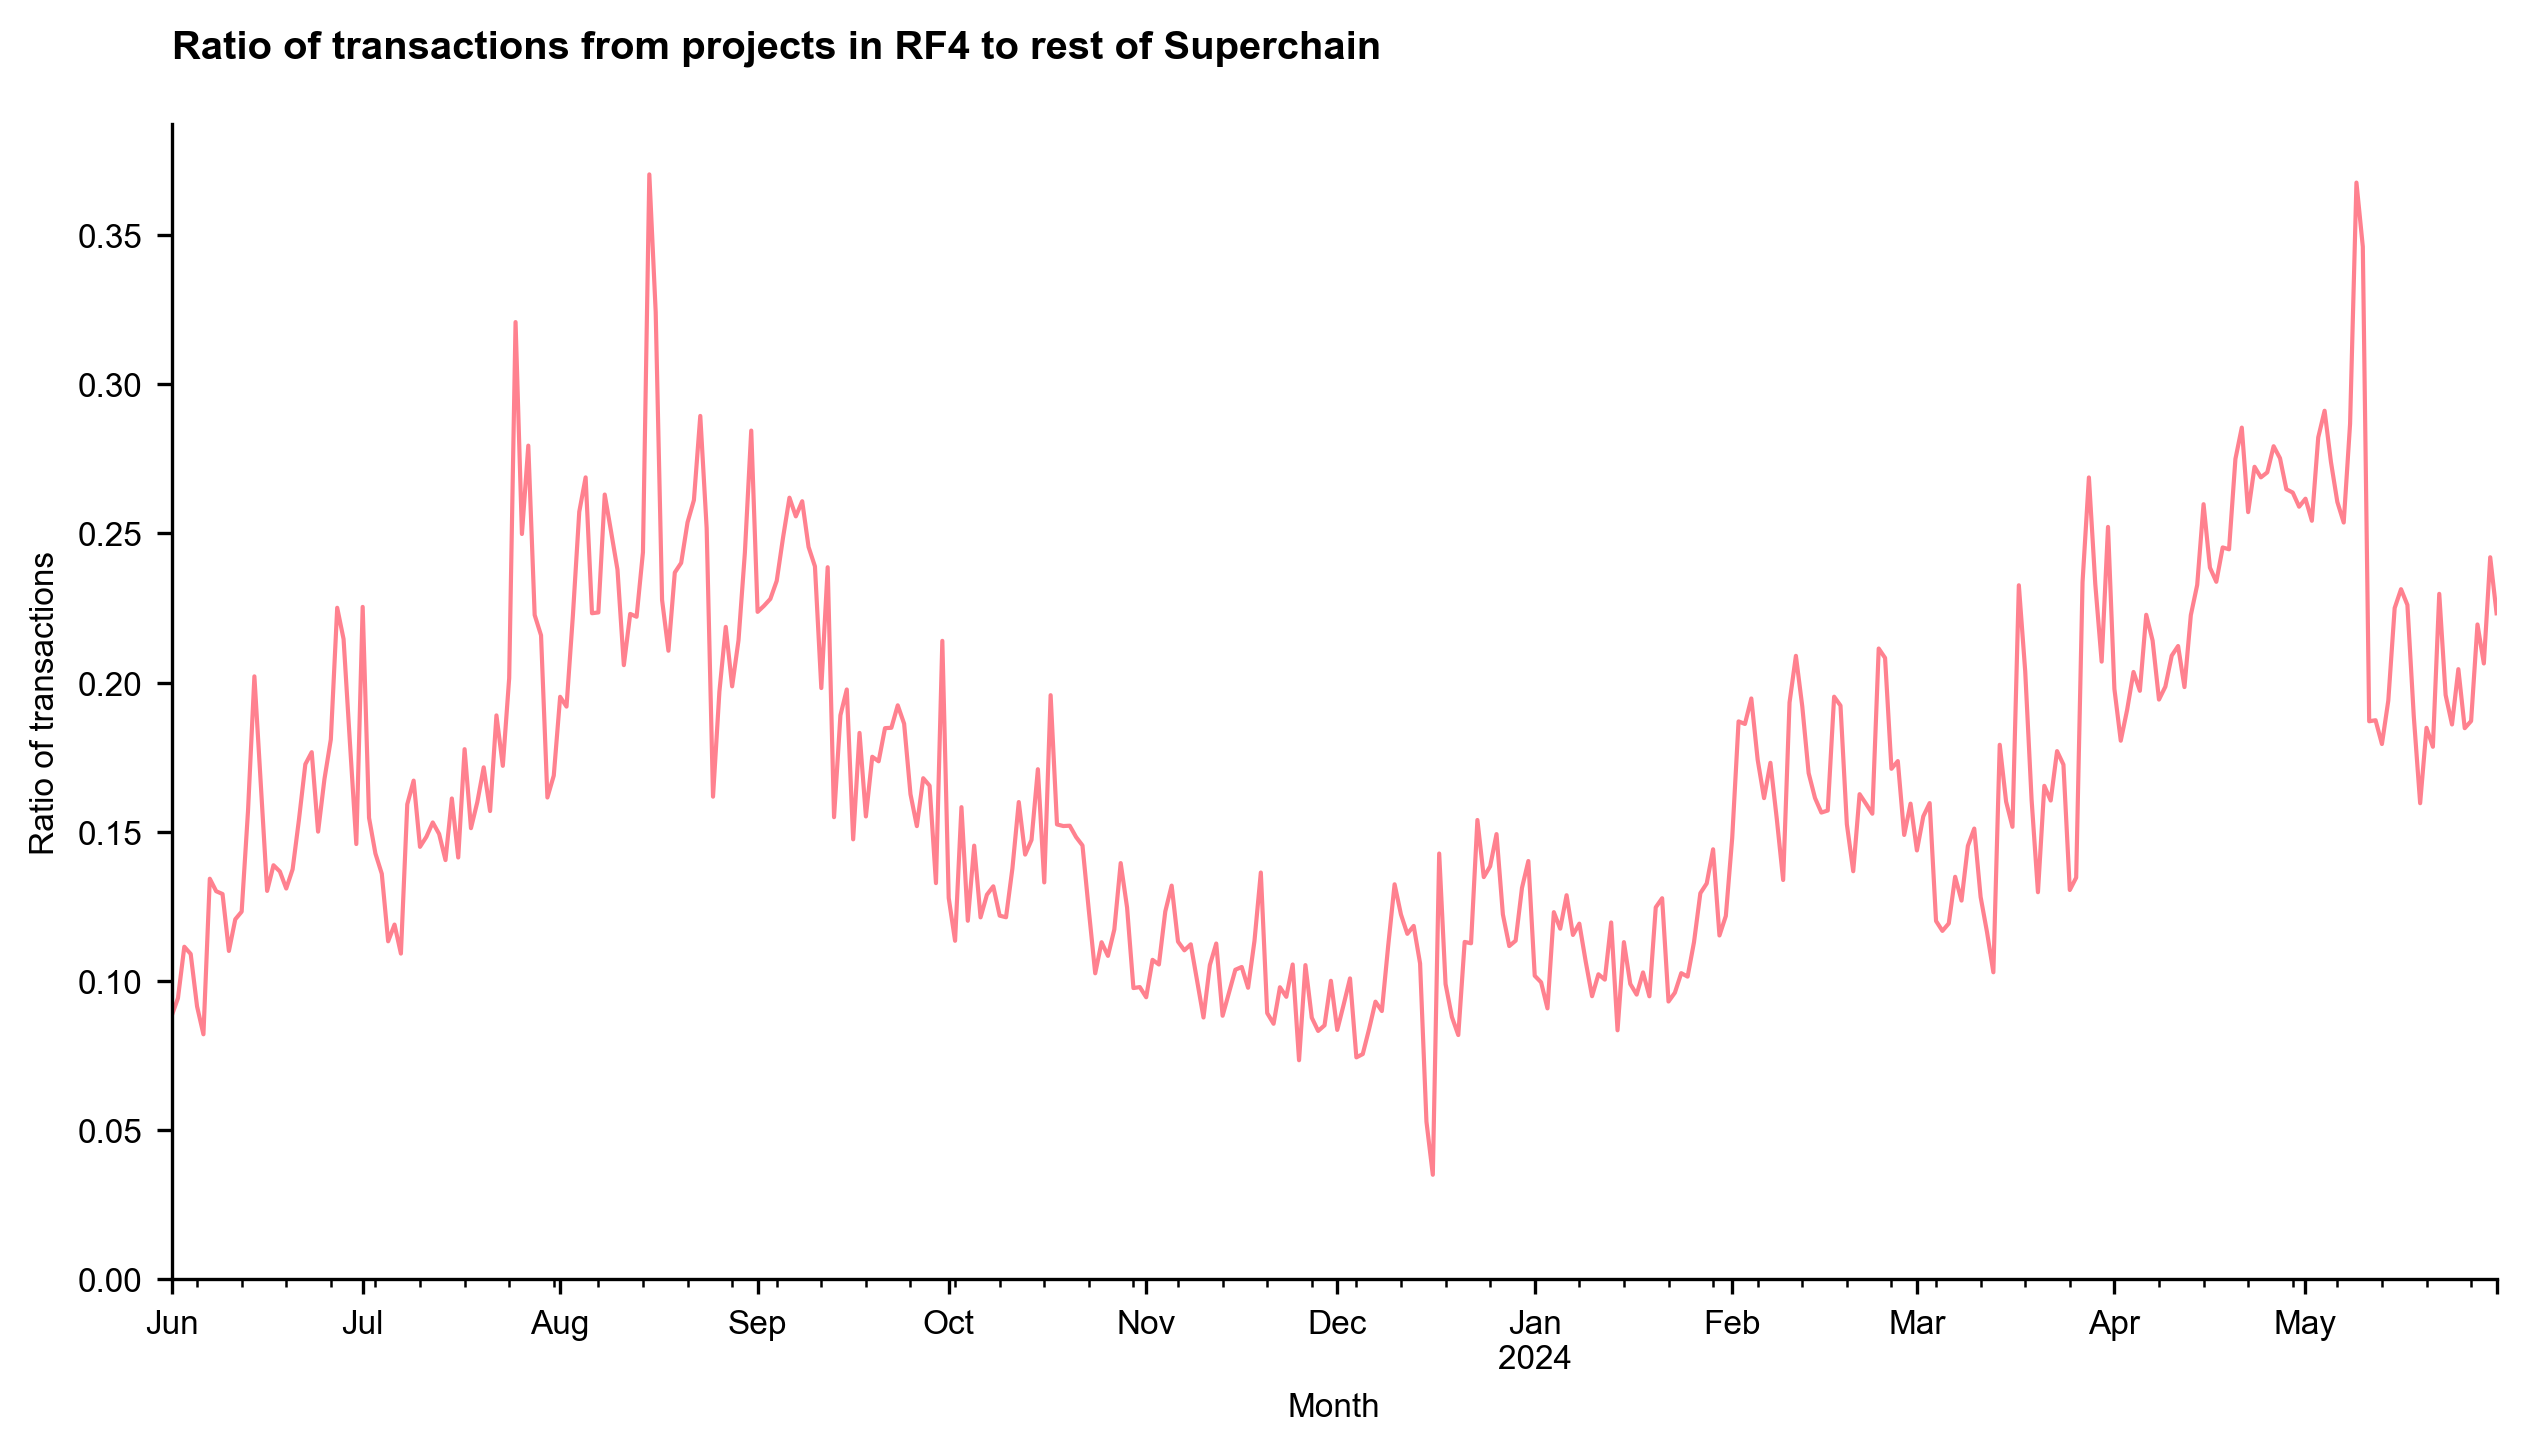

In [21]:
fig, ax = plt.subplots()
(rf4_txns / other_txns).plot(kind='line', color=COLOR1, alpha=.5, lw=1, ax=ax)
ax.set_ylim(0,)
ax.set_ylabel("Ratio of transactions")
ax.set_xlabel("Month")
ax.set_title("Ratio of transactions from projects in RF4 to rest of Superchain\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Daily transactions for projects in RF4 vs other networks\n')

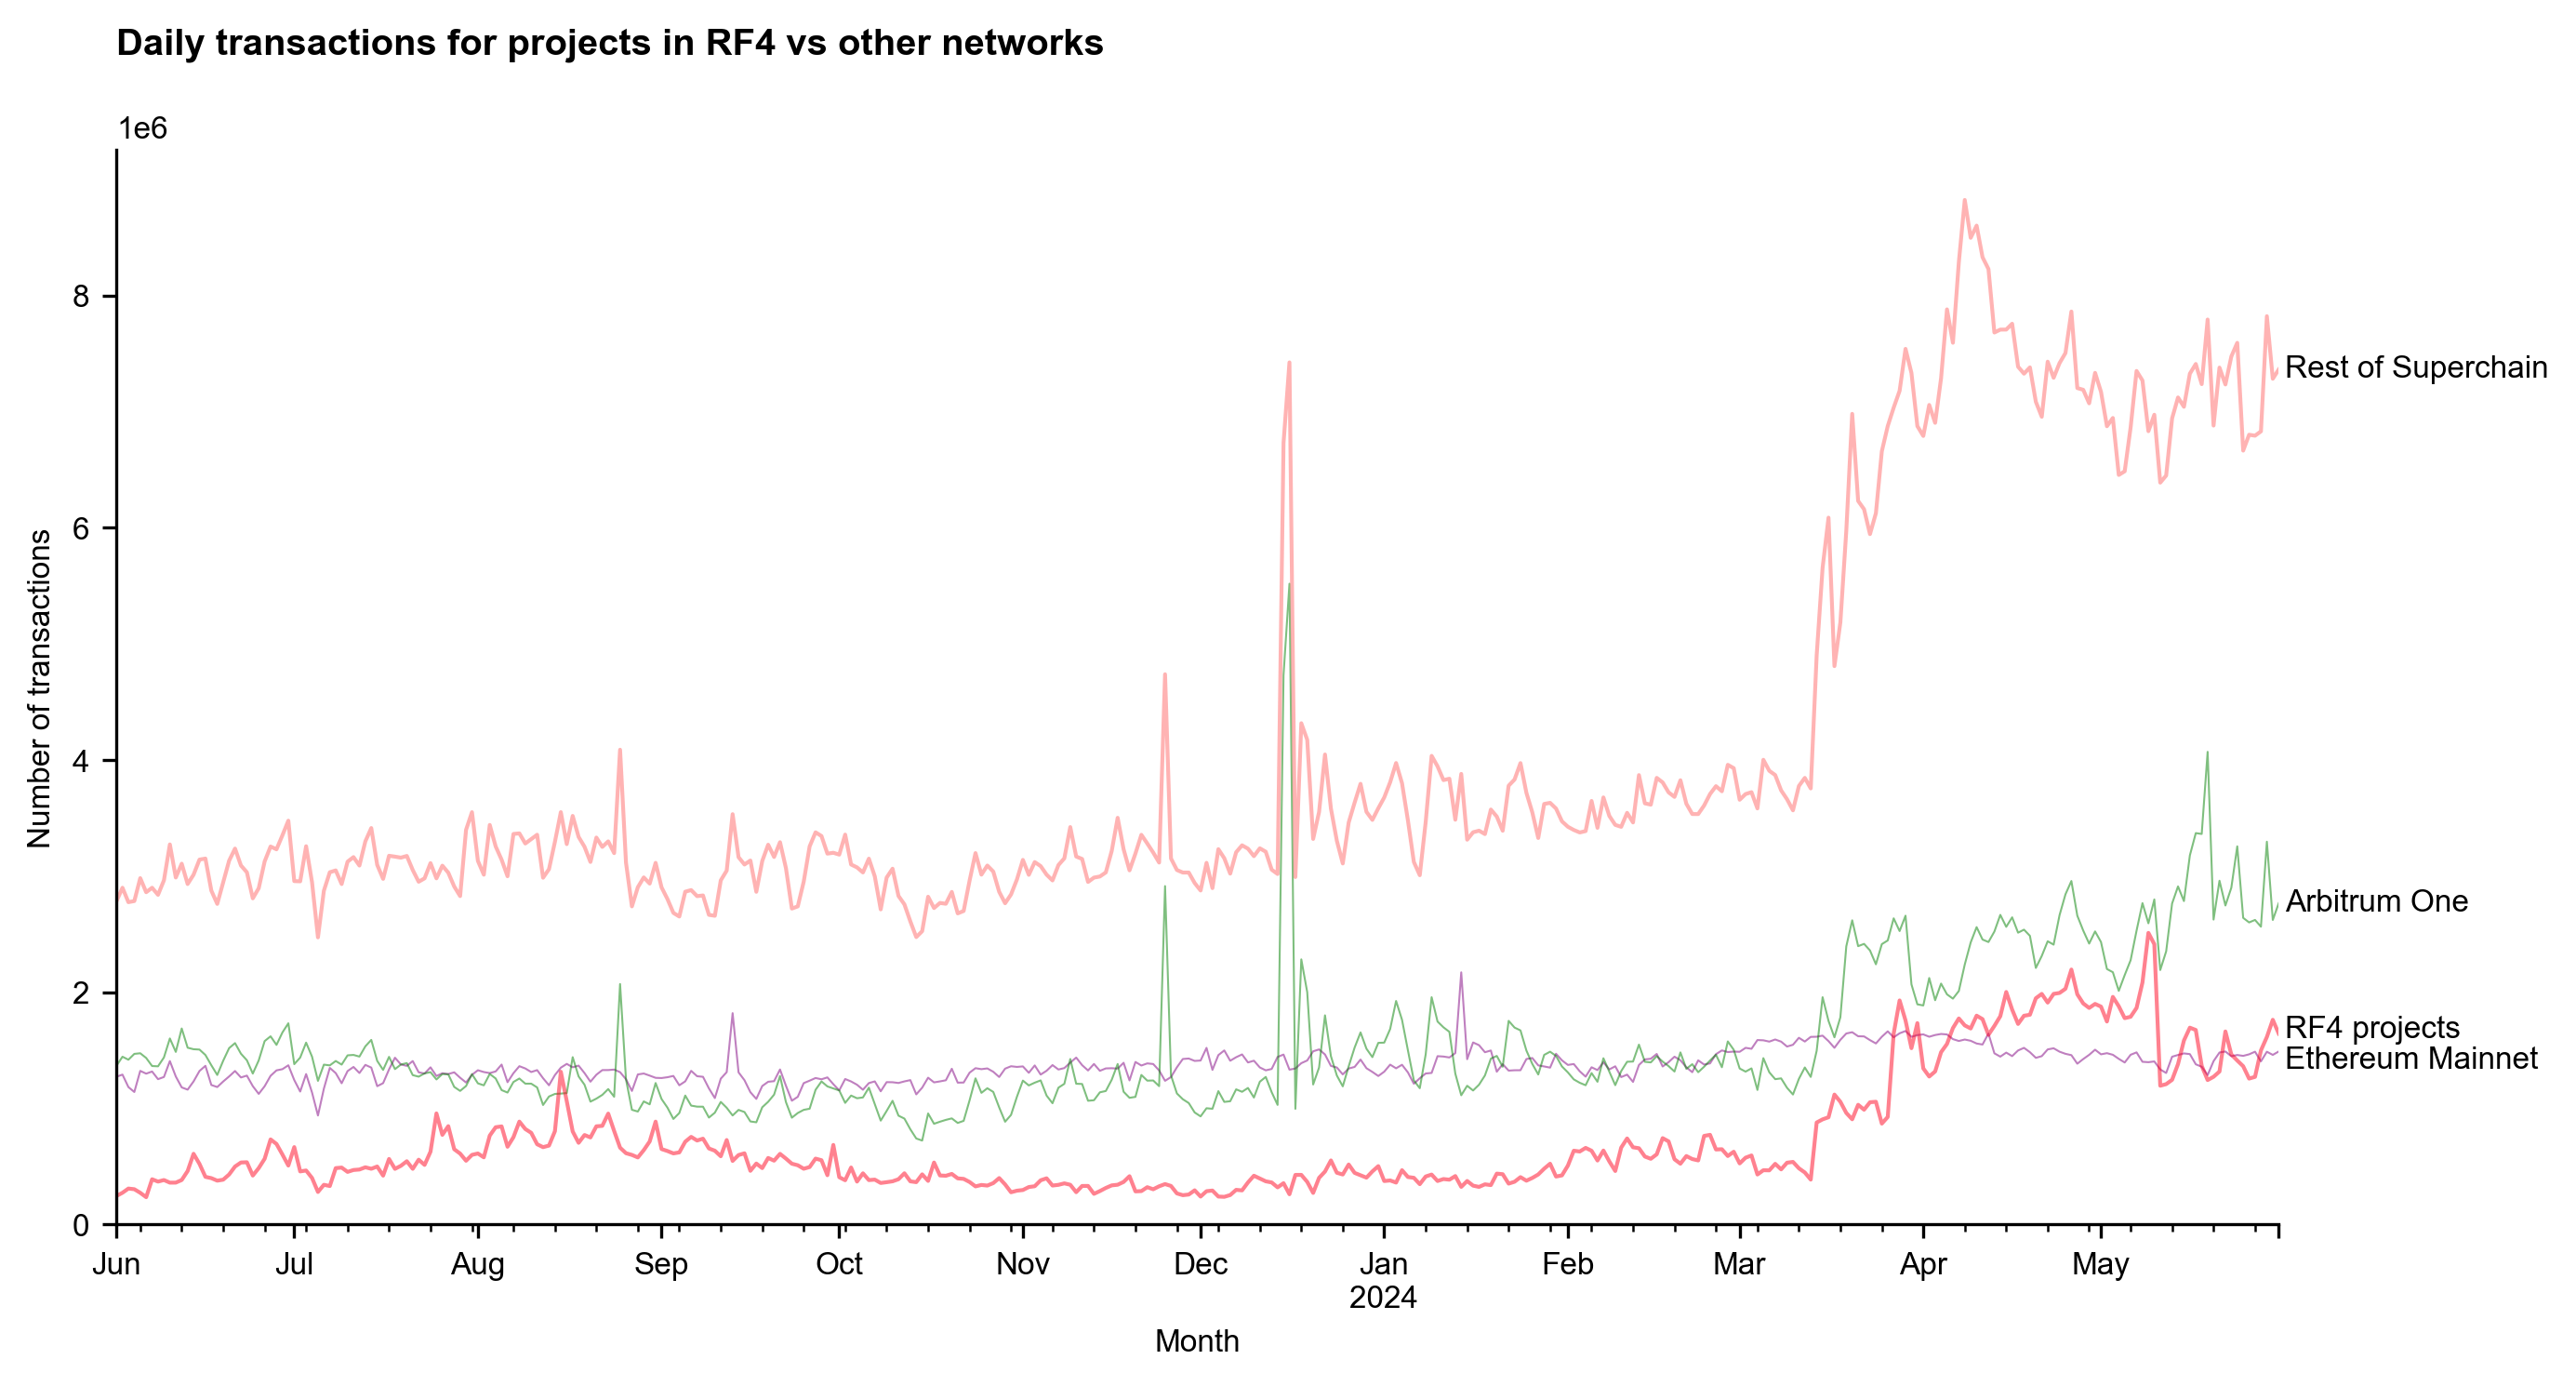

In [22]:
fig, ax = plt.subplots()

eth_txns = df_txns[df_txns['network'] == 'MAINNET'].groupby('bucket_day')['num_txns'].sum()
eth_txns.plot(kind='line', color='purple', alpha=.5, lw=.5, ax=ax)

arb_txns = df_txns[df_txns['network'] == 'ARBITRUM'].groupby('bucket_day')['num_txns'].sum()
arb_txns.plot(kind='line', color='green', alpha=.5, lw=.5, ax=ax)

rf4_txns = (
    df_txns[(df_txns['network'].isin(superchain_networks)) & df_txns['project_id'].isin(rf_projects)==True]
    .groupby('bucket_day')['num_txns'].sum()
)
rf4_txns.plot(kind='line', color=COLOR1, alpha=.5, lw=1, ax=ax)

other_txns = (
    df_txns[(df_txns['network'].isin(superchain_networks)) & df_txns['project_id'].isin(rf_projects)==False]
    .groupby('bucket_day')['num_txns'].sum()
)
other_txns.plot(kind='line', color=COLOR2, alpha=.5, lw=1, ax=ax)

xmax = ax.get_xlim()[-1]
ax.text(x=xmax+1, y=rf4_txns.iloc[-1]*1.02, s="RF4 projects", va='center')
ax.text(x=xmax+1, y=other_txns.iloc[-1], s="Rest of Superchain", va='center')
ax.text(x=xmax+1, y=eth_txns.iloc[-1]*.95, s="Ethereum Mainnet", va='center')
ax.text(x=xmax+1, y=arb_txns.iloc[-1], s="Arbitrum One", va='center')

ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("Month")
ax.set_title("Daily transactions for projects in RF4 vs other networks\n", loc='left', weight='bold')

## Going open source

This exhibit shows the rate of commit activity across 500+ OSS projects that have applied for Retro Funding since the first round. You can see a large number of projects open-sourced their code right before RF4.

In [23]:
events_df = (
    EVENTS_BY_PROJECT
    .query("event_type in ['COMMIT_CODE', 'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT']")
    .pivot_table(
        index='project_id',
        columns='event_type',
        values='bucket_month',
        aggfunc='min'
    )
    .dropna()
    .applymap(lambda x: pd.to_datetime(x.split()[0]))
    .rename(columns={
        'COMMIT_CODE': 'first_commit', 
        'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT': 'first_transaction'
    })
    .join(
        EVENTS_BY_PROJECT
        .query("event_type == 'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT'")
        .groupby('project_id')
        ['amount'].sum()
    )
    .reindex(collections['op-retrofunding-4'])
    .dropna()
    .reset_index()
)
events_df['timedelta'] = events_df['first_commit'] - events_df['first_transaction']
events_df['days'] = events_df['timedelta'].apply(lambda x: x.days)
events_df['project_name'] = events_df['project_id'].map(projects)
events_df['cohort'] = events_df['project_id'].map(project_cohort_mapping)
events_df.head()

project_id first_commit  \
0  N_5JPnxda1IkCryY_tpU-BCvzSt1svTlNkvjuWlYsPw=   2023-02-01   
1  mfn9aiOnHKAUe6YxvFmblJNdaxqWvKbLgk6uyxa46kw=   2024-06-01   
2  1e72O6k-8RzmFpXoNddUpJBTWUW5_utmXLEMblDjz-Y=   2024-06-01   
3  K3XwWcHnGuoik2XEbnqgku5jl6s-agyNWXVPnc9qbt4=   2023-02-01   
4  vYHZl9uHXEdHRUOP8YBanKV8tx3qHuY60q_rxWPwZCQ=   2024-02-01   

  first_transaction    amount timedelta  days   project_name  \
0        2023-05-01    3662.0  -89 days   -89   scryprotocol   
1        2023-09-01   43101.0  274 days   274      titlesnyc   
2        2024-04-01       3.0   61 days    61  createmytoken   
3        2023-02-01  217875.0    0 days     0      overnight   
4        2024-02-01    1362.0    0 days     0      trashnfts   

                  cohort  
0   Returning RF project  
1  First-time RF project  
2  First-time RF project  
3  First-time RF project  
4  First-time RF project

Text(0.5, 0, 'Month of first public commit')

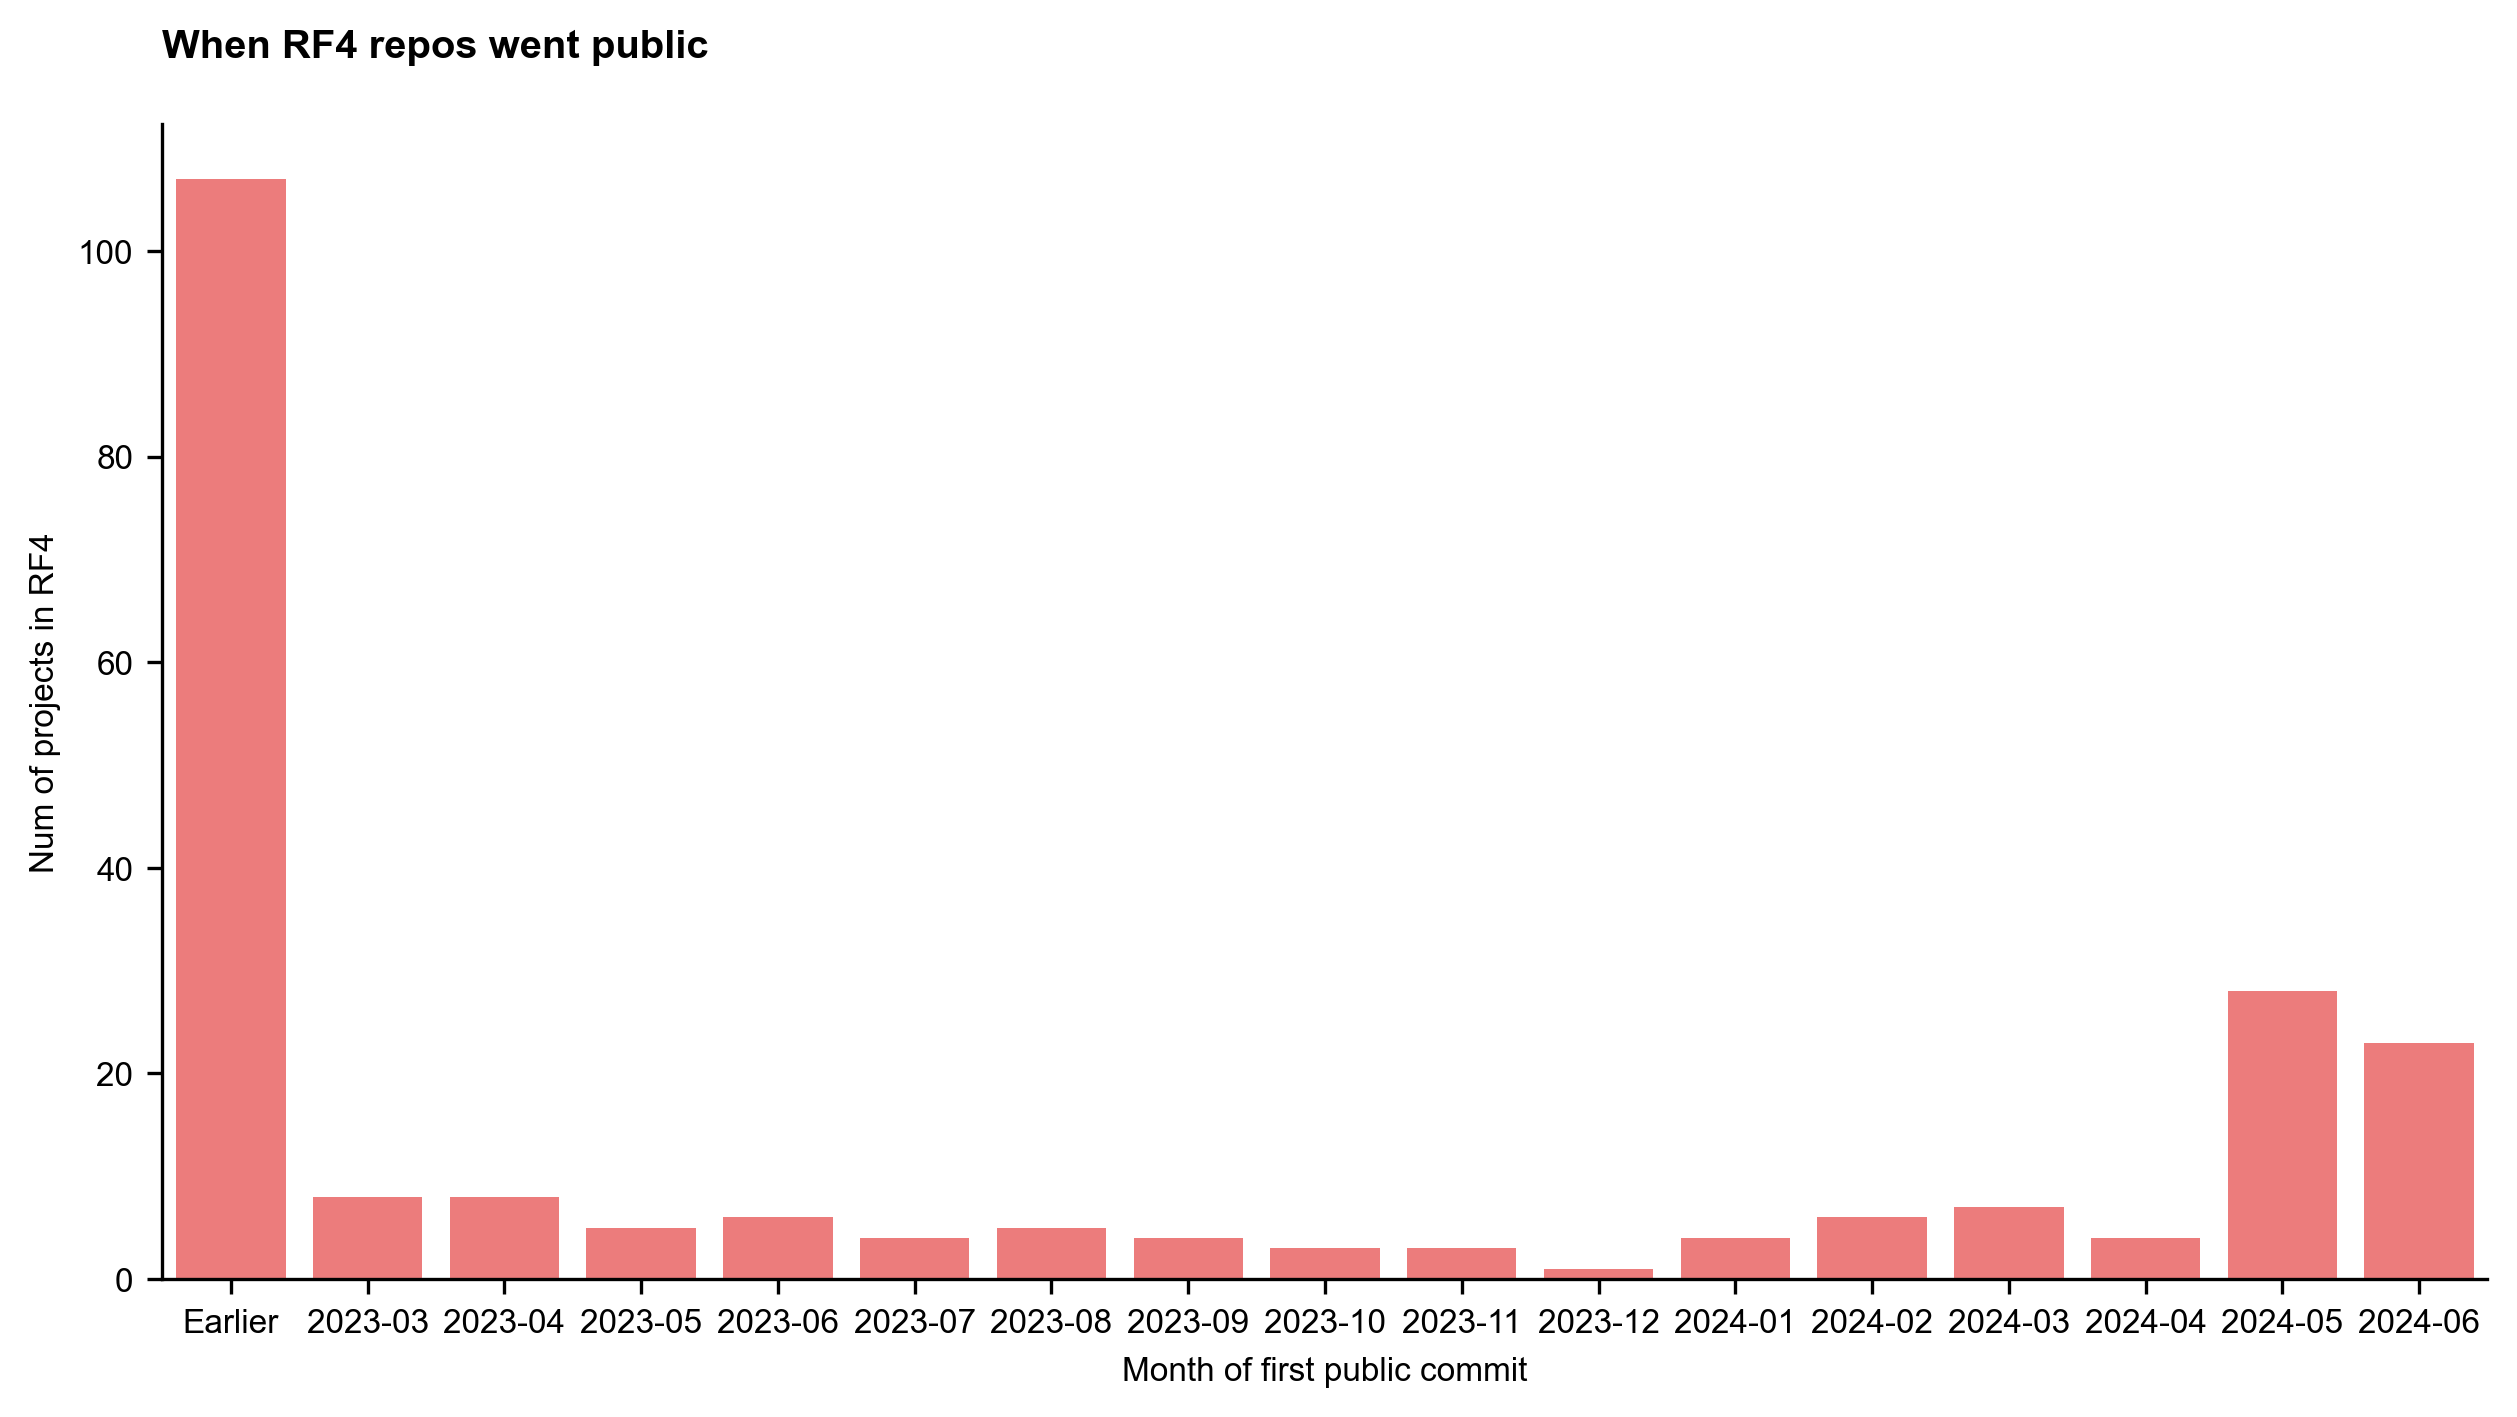

In [24]:
fig, ax = plt.subplots()

commit_history = (
    events_df[events_df['project_id'].isin(collections['op-retrofunding-4'])]
    .groupby('first_commit')['project_id']
    .count()
    .reset_index()
)

commit_history['first_commit'] = pd.to_datetime(commit_history['first_commit'])
sns.barplot(
    data=commit_history,
    x='first_commit',
    y='project_id',
    color=COLOR2,
    ax=ax
)

labels = [item.get_text() for item in ax.get_xticklabels()]
formatted_labels = [
    pd.to_datetime(label).strftime('%Y-%m')
    if i > 0
    else 'Earlier'
    for i,label in enumerate(labels)
]
ax.set_xticklabels(formatted_labels)
ax.set_title("When RF4 repos went public\n", loc='left', weight='bold')
ax.set_ylabel("Num of projects in RF4")
ax.set_xlabel("Month of first public commit")

51 projects in RF4 made their first public commit after 2024-05-01


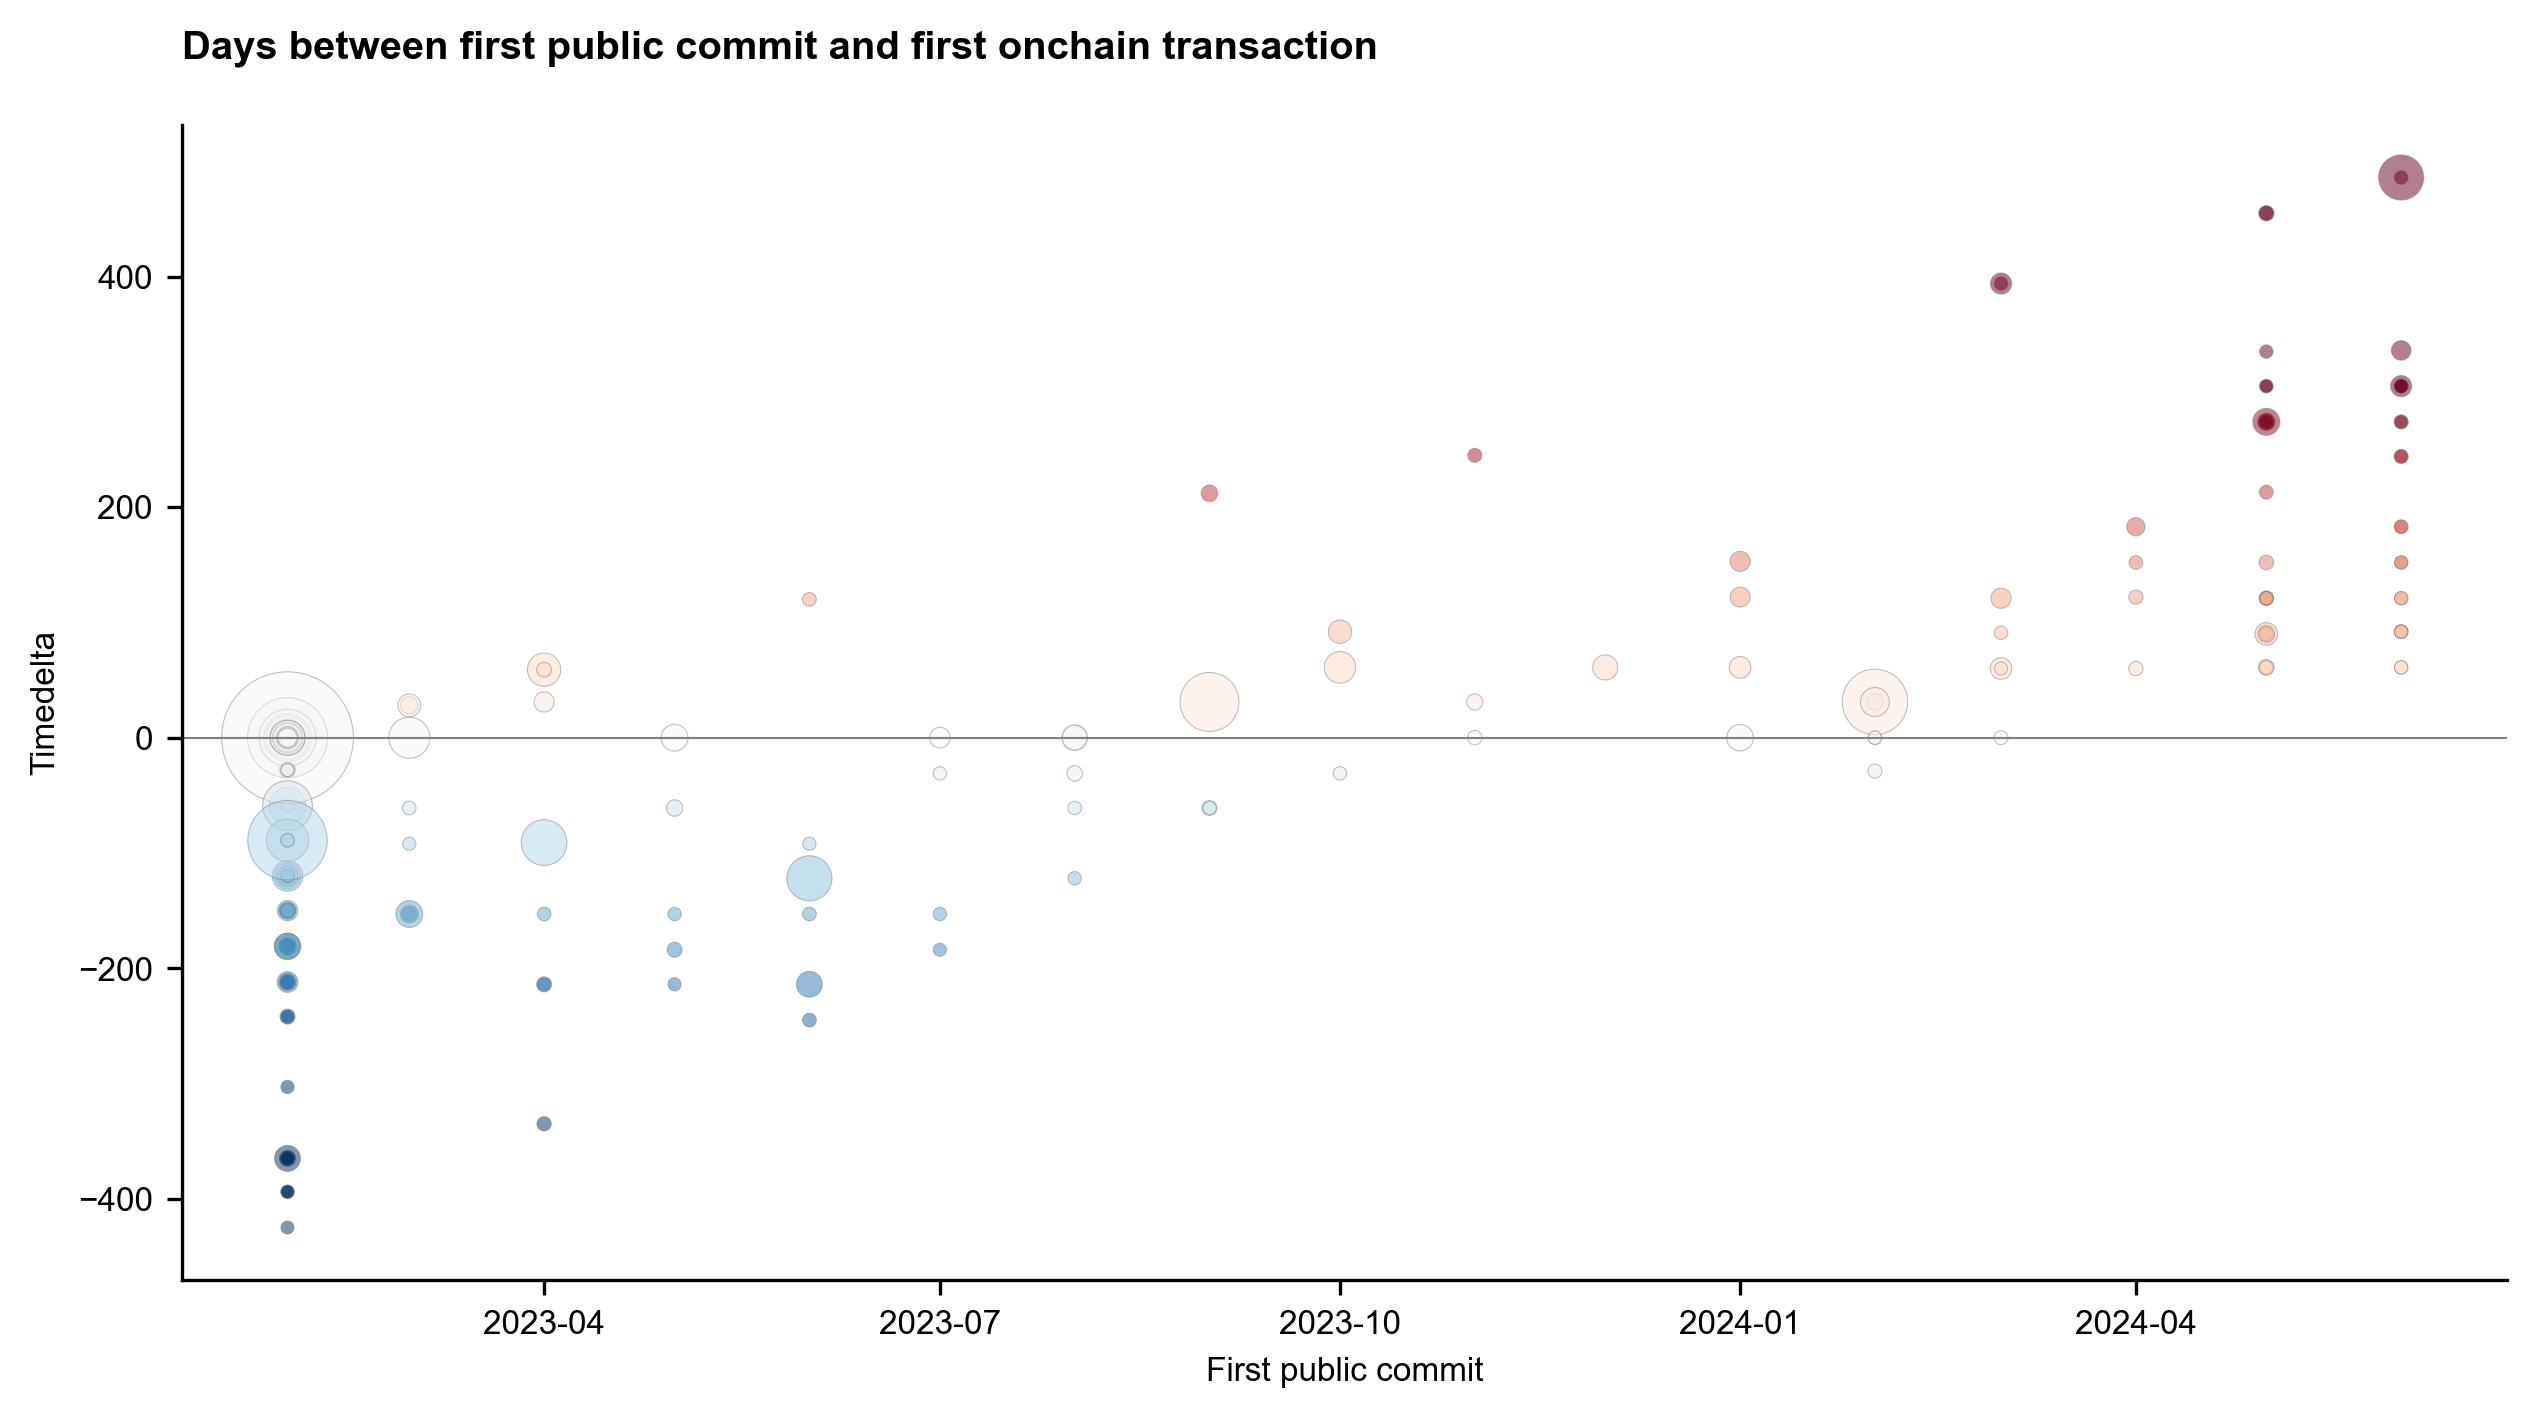

In [25]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=events_df,
    x='first_commit',
    y='days',    
    size='amount',
    sizes=(10,1000),
    alpha=.5,
    hue='days',
    palette='RdBu_r',
    hue_norm=(-300,300),
    edgecolor='gray',
    legend=False,
    ax=ax
)
ax.axhline(y=0, color='gray', lw=.5)
ax.set_title("Days between first public commit and first onchain transaction\n", loc='left', weight='bold')
ax.set_ylabel("Timedelta")
ax.set_xlabel("First public commit")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

rf4_date = pd.to_datetime('2024-05-01')
late_commits = len(events_df[(events_df['days'] > 30) & (events_df['first_commit'] >= rf4_date)])
print(f"{late_commits} projects in RF4 made their first public commit after 2024-05-01")

# Bonus: Banner Image

In [26]:
from contribution_heatmap import contribution_heatmap

hm = (
    dev_df[dev_df['cohort'] != 'Never received RF']
    .groupby(['project_name', 'bucket_month'])['fulltime_active_dev']
    .sum()
    .reset_index()
)
hm['bucket_month'] = hm['bucket_month'].apply(lambda x: str(x).split(' ')[0][:-3])

contribution_heatmap(
    dataframe=hm,
    index_col='project_name',
    column_col='bucket_month',
    value_col='fulltime_active_dev',
    sort_label_method='mean',
    linewidths=.1,
    figsize=(10,80),
)

(<Figure size 3000x24000 with 1 Axes>, <Axes: >)